#### App Initialization

In [98]:
# Import statements and app initialization
import pandas as pd
import numpy as np
import re
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [99]:
# Read loan csv
df_loan = pd.read_csv('loan.csv')

In [100]:
# Get loan columns
loan_columns = list(df_loan.columns)
loan_columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

#### Reusable Functions

In [101]:
def isna(value):
    try:
        return np.isnan(value)
    except:
        return False

def convert_percent_to_number(value, type='float', decimal_place=2):
    if type == 'float':
        return round(float(value.strip().rstrip('%')), decimal_place)
    else:
        return int(value.strip().rstrip('%'))

def segmented_pivot_table(column, df=df_loan):
    status_counts = df.groupby([column, 'loan_status']).size().unstack(fill_value=0)
    # Calculate the total number of loans for each column value
    status_counts['Total'] = status_counts.sum(axis=1)
    # Calculate the percentage of charged-off loans
    status_counts['Charged Off Percentage'] = (status_counts['Charged Off'] / status_counts['Total']) * 100
    status_counts['Fully Paid Percentage'] =  (status_counts['Fully Paid'] / status_counts['Total']) * 100
    return status_counts.sort_values(by='Charged Off Percentage', ascending=False)

def remove_outliers(column):
    # From formula upper whisker handle is at Q3 + 1.5*IQR where IQR = Q3 - Q1
    stats = df_loan[column].describe()
    valid_upper_whisker_handle_value = stats['75%'] + 1.5 * (stats['75%'] - stats['25%'])
    return df_loan[df_loan[column] <= valid_upper_whisker_handle_value]
    
def create_bivariate_chart(df, col_name, rot=0):
    # Group by the column and loan_status, then calculate the percentage of 'Charged Off' loans
    col_name_loan_status = df.groupby([col_name, 'loan_status']).size().unstack()
    col_name_loan_status['total'] = col_name_loan_status.sum(axis=1)
    col_name_loan_status['Percentage'] = (col_name_loan_status['Charged Off'] / col_name_loan_status['total']) * 100

    # Create a bar plot for the percentage of 'Charged Off' loans
    plt.figure(figsize=(15, 7))
    bars = col_name_loan_status['Percentage'].plot(kind='bar', color='skyblue')
    plt.xlabel(col_name)
    plt.ylabel('Percentage of Charged Off loans')
    plt.title(f'Percentage of Charged Off loans by {col_name}')
    plt.xticks(rotation=rot)

    # Add percentage labels on top of the bars
    for bar in bars.patches:
        plt.annotate(format(bar.get_height(), '.1f'),
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='center', size=10, xytext=(0, 8),
                     textcoords='offset points')
    plt.show()

#### Fix Columns

##### Removing columns that has just 1 unique value. These columns cannot be driving variables and cannot help in analysis.

In [102]:
# Get columns that has 1 unique value count. These columns cannot be driving variables and cannot help us in analyzing so removing it

def get_columns_by_expected_unique_count(expected_unique_count = 1):
    result = []
    for column in loan_columns:
        unique_values = df_loan[column].unique()
        unique_count = len(unique_values)
        if unique_count == expected_unique_count:
            result.append(column)
    return result
    
loan_irrelevant_columns = get_columns_by_expected_unique_count(1)
loan_irrelevant_columns

['pymnt_plan',
 'initial_list_status',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_

In [103]:
# Removing irrelevant columns
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(loan_irrelevant_columns, axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 111)
Shape after removing columns (39717, 51)


In [104]:
# Update loan columns variable
loan_columns = list(df_loan.columns)
loan_columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'chargeoff_within_12_mths',
 'pub_rec_bankruptcies',
 'tax_liens']

In [105]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [106]:
# As next_pymnt_d has only 2.28% non null values and mths_since_last_record has 7% non-null values, and these variables null values cannot be imputed
# thus they cannot be driving variable and cannot help us in analysis so removing these columns
# Removing irrelevant columns
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['next_pymnt_d', 'mths_since_last_record'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 51)
Shape after removing columns (39717, 49)


In [107]:
# Removing those columns as well where null values are greater than 50%. These columns cannot be driving variables and cannot help in overall analysis
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['mths_since_last_delinq'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 49)
Shape after removing columns (39717, 48)


In [108]:
# Removing columns that are neither categorical nor quantative. They cannot help us in analysis
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['desc'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 48)
Shape after removing columns (39717, 47)


In [109]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [110]:
# As we have to analyze for new customers applying for loan, so there are certain fields which we can remove as they will not be provided in the application
# This data will not be available when customer will apply for loan and bank cannot analyze customer profile based on these fields
fields_not_available_application_time = ['out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d']
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(fields_not_available_application_time, axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 47)
Shape after removing columns (39717, 36)


In [111]:
# Even A grade customers are found to have high revolving utilization rate(revol_util) as such revol_util cannot help us in determining risk associated with new customers.
# Total credit accounts(total_acc) is not necessary as we are keeping open credit accounts (open_acc)
# Loan inquiries in last 6 month cannot help us in getting any insight of new customer(inq_last_6mths) so removing it
# Customer will not be able to provide delinquishments in last 2 year(delinq_2yrs) so removing it
# Removing title and emp_title as they cannot provide any insight on risk associated with new customer
# Removing revolving account balance as from revolving account balance(revol_bal) can be withdrawn and repay anytime. It can impact proper analysis. Instead of it keep outstanding principal which is fixed metric to get proper analysis
to_remove_columns = ['revol_util', 'total_acc', 'inq_last_6mths', 'delinq_2yrs', 'title', 'emp_title', 'revol_bal']
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(to_remove_columns, axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 36)
Shape after removing columns (39717, 29)


In [112]:
# pub_rec_bankruptcies has less relevant data as compare to pub_rec. So removing this column
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['pub_rec_bankruptcies'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 29)
Shape after removing columns (39717, 28)


#### Fix Rows

##### Handling rows having null columns.

In [113]:
# Maximum non-null rows are 39717. Checking which column has less non-null rows and figure out reason behind it.

In [114]:
# After latest update 2.7% of customers has null employee length. NULL employee length creates no meaning and it cannot be imputed as well, so removing
# records with null emp_length. As records are very small so it should the impact overall analysis.
df_loan = df_loan[~df_loan['emp_length'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38642 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38642 non-null  int64  
 1   member_id                   38642 non-null  int64  
 2   loan_amnt                   38642 non-null  int64  
 3   funded_amnt                 38642 non-null  int64  
 4   funded_amnt_inv             38642 non-null  float64
 5   term                        38642 non-null  object 
 6   int_rate                    38642 non-null  object 
 7   installment                 38642 non-null  float64
 8   grade                       38642 non-null  object 
 9   sub_grade                   38642 non-null  object 
 10  emp_length                  38642 non-null  object 
 11  home_ownership              38642 non-null  object 
 12  annual_inc                  38642 non-null  float64
 13  verification_status         38642 no

In [115]:
# As of the latest update, 0.14% of data has collections_12_mths_ex_med NULL. As this value cannot be imputed and cannot help us in analysis,
# we can remove rows having this column NULL value.
df_loan = df_loan[~df_loan['collections_12_mths_ex_med'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38586 non-null  int64  
 1   member_id                   38586 non-null  int64  
 2   loan_amnt                   38586 non-null  int64  
 3   funded_amnt                 38586 non-null  int64  
 4   funded_amnt_inv             38586 non-null  float64
 5   term                        38586 non-null  object 
 6   int_rate                    38586 non-null  object 
 7   installment                 38586 non-null  float64
 8   grade                       38586 non-null  object 
 9   sub_grade                   38586 non-null  object 
 10  emp_length                  38586 non-null  object 
 11  home_ownership              38586 non-null  object 
 12  annual_inc                  38586 non-null  float64
 13  verification_status         38586 no

In [116]:
# Looking for duplicate rows. No duplicate row exist
df_loan[df_loan.duplicated()]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,out_prncp,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens


In [117]:
# No unecessary header or footer rows in data. 
# All empty/blank rows must be removed in null value checks
# There are no column number indicator rows
# There are no total/sub-total rows

#### Fix Data type

In [118]:
# term is a categorical variable has only 2 possible values 36 month and 60 month. There values are wrongly formatted have spaces around them and
# we can just keep them integer and assume that term is in month only. 
def validate_term(value):
    return int(value.strip().rstrip('month').rstrip('months').strip())

df_loan['term'] = df_loan['term'].apply(validate_term)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38586 non-null  int64  
 1   member_id                   38586 non-null  int64  
 2   loan_amnt                   38586 non-null  int64  
 3   funded_amnt                 38586 non-null  int64  
 4   funded_amnt_inv             38586 non-null  float64
 5   term                        38586 non-null  int64  
 6   int_rate                    38586 non-null  object 
 7   installment                 38586 non-null  float64
 8   grade                       38586 non-null  object 
 9   sub_grade                   38586 non-null  object 
 10  emp_length                  38586 non-null  object 
 11  home_ownership              38586 non-null  object 
 12  annual_inc                  38586 non-null  float64
 13  verification_status         38586 no

In [119]:
# int_rate is a quantative variable. There values are wrongly formatted by keeping percent in the end
# we can convert it to float by removing percent. 
df_loan['int_rate'] = df_loan['int_rate'].apply(convert_percent_to_number)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38586 non-null  int64  
 1   member_id                   38586 non-null  int64  
 2   loan_amnt                   38586 non-null  int64  
 3   funded_amnt                 38586 non-null  int64  
 4   funded_amnt_inv             38586 non-null  float64
 5   term                        38586 non-null  int64  
 6   int_rate                    38586 non-null  float64
 7   installment                 38586 non-null  float64
 8   grade                       38586 non-null  object 
 9   sub_grade                   38586 non-null  object 
 10  emp_length                  38586 non-null  object 
 11  home_ownership              38586 non-null  object 
 12  annual_inc                  38586 non-null  float64
 13  verification_status         38586 no

In [120]:
# Converting date string field to datetime
#pd.to_datetime(df_loan['issue_d'])
#pd.to_datetime(df_loan['issue_d'], format='%b-%y')
df_loan['issue_d'] = pd.to_datetime(df_loan['issue_d'], format='%b-%y')
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          38586 non-null  int64         
 1   member_id                   38586 non-null  int64         
 2   loan_amnt                   38586 non-null  int64         
 3   funded_amnt                 38586 non-null  int64         
 4   funded_amnt_inv             38586 non-null  float64       
 5   term                        38586 non-null  int64         
 6   int_rate                    38586 non-null  float64       
 7   installment                 38586 non-null  float64       
 8   grade                       38586 non-null  object        
 9   sub_grade                   38586 non-null  object        
 10  emp_length                  38586 non-null  object        
 11  home_ownership              38586 non-null  object        


In [121]:
# Fixing type of earliest_cr_line
df_loan['earliest_cr_line'] = pd.to_datetime(df_loan['earliest_cr_line'], format='%b-%y')
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          38586 non-null  int64         
 1   member_id                   38586 non-null  int64         
 2   loan_amnt                   38586 non-null  int64         
 3   funded_amnt                 38586 non-null  int64         
 4   funded_amnt_inv             38586 non-null  float64       
 5   term                        38586 non-null  int64         
 6   int_rate                    38586 non-null  float64       
 7   installment                 38586 non-null  float64       
 8   grade                       38586 non-null  object        
 9   sub_grade                   38586 non-null  object        
 10  emp_length                  38586 non-null  object        
 11  home_ownership              38586 non-null  object        


In [122]:
# Setting correct type in emp_length
def convert_emp_length_valid_value(value):
    without_space = value.replace(' ', '')
    if without_space.startswith('<1'):
        return 0
    elif without_space.startswith('10+'):
        return 10
    else:
        return int(without_space.rstrip('year').rstrip('years'))

df_loan['emp_length'] = df_loan['emp_length'].apply(convert_emp_length_valid_value)
df_loan['emp_length'].unique()

array([10,  0,  1,  3,  8,  9,  4,  5,  6,  2,  7], dtype=int64)

In [123]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          38586 non-null  int64         
 1   member_id                   38586 non-null  int64         
 2   loan_amnt                   38586 non-null  int64         
 3   funded_amnt                 38586 non-null  int64         
 4   funded_amnt_inv             38586 non-null  float64       
 5   term                        38586 non-null  int64         
 6   int_rate                    38586 non-null  float64       
 7   installment                 38586 non-null  float64       
 8   grade                       38586 non-null  object        
 9   sub_grade                   38586 non-null  object        
 10  emp_length                  38586 non-null  int64         
 11  home_ownership              38586 non-null  object        


In [124]:
# Rulling out all current status loan as they cannot provide any insight
df_loan = df_loan[df_loan['loan_status'] != 'Current']
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37488 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          37488 non-null  int64         
 1   member_id                   37488 non-null  int64         
 2   loan_amnt                   37488 non-null  int64         
 3   funded_amnt                 37488 non-null  int64         
 4   funded_amnt_inv             37488 non-null  float64       
 5   term                        37488 non-null  int64         
 6   int_rate                    37488 non-null  float64       
 7   installment                 37488 non-null  float64       
 8   grade                       37488 non-null  object        
 9   sub_grade                   37488 non-null  object        
 10  emp_length                  37488 non-null  int64         
 11  home_ownership              37488 non-null  object        


In [125]:
# Remove rows where home_ownership is NONE, because it is just 1 record have no significance
df_loan = df_loan[df_loan['home_ownership'] != 'NONE']

In [126]:
# Standardization is not needed with given data. 

#### Fixing Invalid Values

In [127]:
# All zip codes follows expected format
list(filter(lambda x: not(re.search("^\d{3}xx$", x)), df_loan['zip_code'].unique()))

[]

In [128]:
# Removing invalid value from earliest_cr_line. earliest_cr_line contains value greater than current year which is not possible
current_year = datetime.datetime.now().year #get current year
print("Shape before removing rows {0}".format(df_loan.shape))
df_loan = df_loan[df_loan['earliest_cr_line'].dt.year <= current_year]
print("Shape before removing rows {0}".format(df_loan.shape))

Shape before removing rows (37487, 28)
Shape before removing rows (37428, 28)


In [129]:
# Valid as 0 rows as loan disbursed amount cannot be greater than loan amount(amount asked in application)
df_loan[df_loan['loan_amnt'] < df_loan['funded_amnt']]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,out_prncp,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens


In [130]:
# Valid as 0 rows as loan disbursed amount by investor cannot be greater than loan amount(asked in application)
df_loan[df_loan['loan_amnt'] < df_loan['funded_amnt_inv']]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,out_prncp,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens


In [131]:
# Valid as 0 rows as loan disbursed amount by investor cannot be greater than loan disbursed amount by bank
df_loan[df_loan['funded_amnt'] < df_loan['funded_amnt_inv']]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,out_prncp,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens


#### Final Cleaning

In [132]:
# After all above cleaning, it looks like there are no other invalid values in data.
# As a side-effect of cleaning, some columns emerge with only 1 unique value. Removing those columns, as these columns cannot help in analysis
print("Shape before removing columns {0}".format(df_loan.shape))
loan_columns = list(df_loan.columns)
print(get_columns_by_expected_unique_count(1))
df_loan.drop(get_columns_by_expected_unique_count(1), axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (37428, 28)
['out_prncp', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens']
Shape after removing columns (37428, 24)


In [133]:
# Removing those columns which cannot help in analysis as they are neither categorical nor quantative variables. These variables can neither help
# in segmented univariant analysis and nor in bivariant analysis
df_loan.drop(['url', 'id', 'member_id'], axis=1, inplace=True)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37428 entries, 0 to 39665
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loan_amnt            37428 non-null  int64         
 1   funded_amnt          37428 non-null  int64         
 2   funded_amnt_inv      37428 non-null  float64       
 3   term                 37428 non-null  int64         
 4   int_rate             37428 non-null  float64       
 5   installment          37428 non-null  float64       
 6   grade                37428 non-null  object        
 7   sub_grade            37428 non-null  object        
 8   emp_length           37428 non-null  int64         
 9   home_ownership       37428 non-null  object        
 10  annual_inc           37428 non-null  float64       
 11  verification_status  37428 non-null  object        
 12  issue_d              37428 non-null  datetime64[ns]
 13  loan_status          37428 non-null 

#### Data Description / Metadata Analysis

##### First we plot metadata analysis and classify the available columns in ordered categorical, unordered categorical and numeric(or quantative). Here is the analysis:
<table border="1">
  <thead>
    <tr>
      <th>Column Name</th>
      <th>Type</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>loan_amnt</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>funded_amnt</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>funded_amnt_inv</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>term</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>int_rate</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>installment</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>grade</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>sub_grade</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>home_ownership</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>annual_inc</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>verification_status</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>issue_d</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>loan_status</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>purpose</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>zip_code</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>addr_state</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>dti</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>earliest_cr_line</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>open_acc</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>pub_rec</td>
      <td>Numeric</td>
    </tr>
  </tbody>
</table>
</table>
Categorical
pub_rec_bankruptcies	Numeric

#### Univariate Analysis for Categorical Unordered Variable

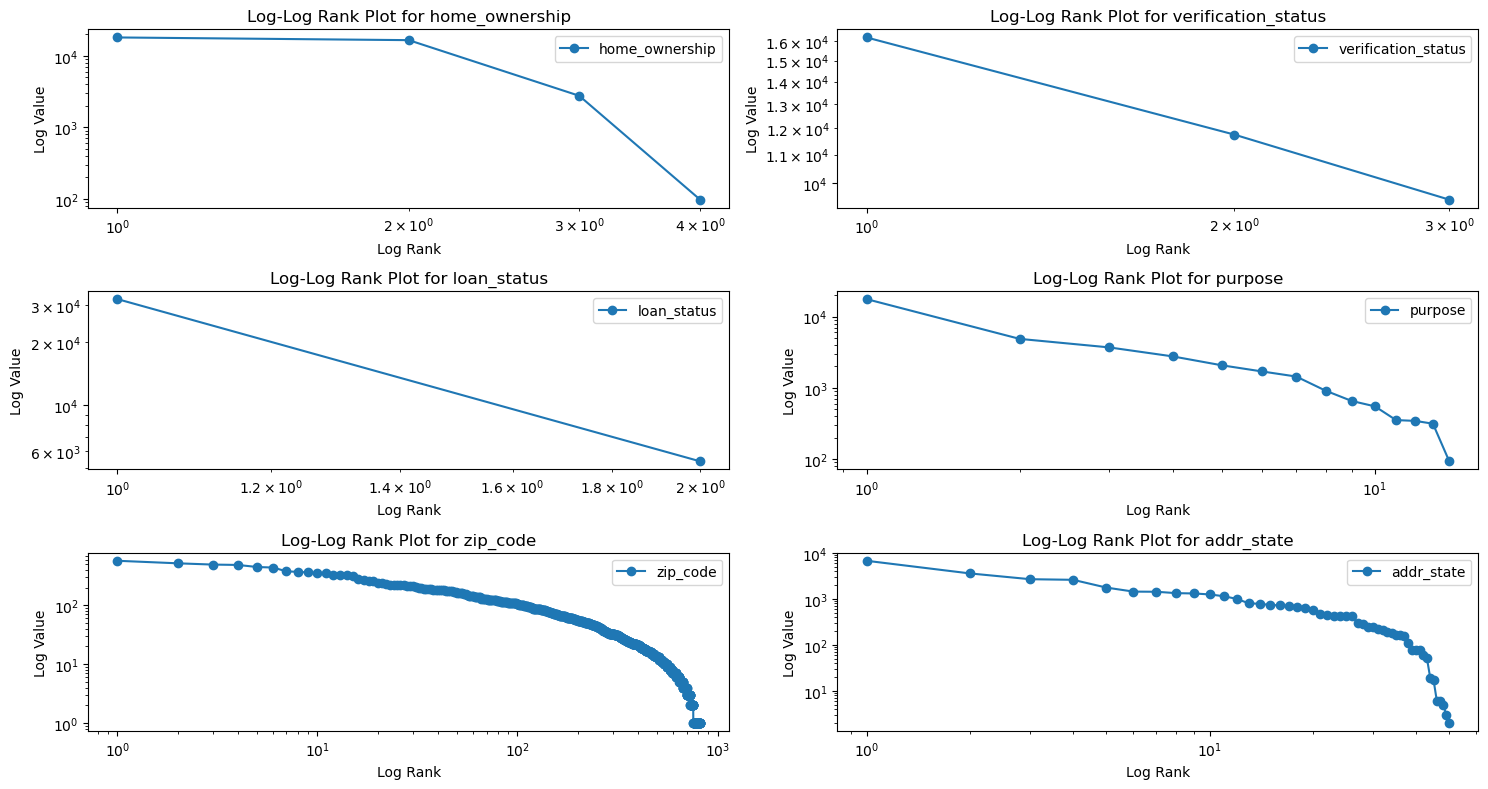

In [134]:
categorical_unordered = ['home_ownership', 'verification_status', 'loan_status', 'purpose', 'zip_code', 'addr_state']
nrows = math.ceil(len(categorical_unordered) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 8))
for i, column in enumerate(categorical_unordered):
    # Rank Plot
    row = i // ncols  # Calculate the row index
    col = i % ncols   # Calculate the column index
    sorted_values = df_loan[column].value_counts().sort_values(ascending=False)
    ranks = range(1, len(sorted_values) + 1)
    axes[row, col].loglog(ranks, sorted_values, marker='o', linestyle='-', label=f'{column}')
    axes[row, col].set_title(f'Log-Log Rank Plot for {column}')
    axes[row, col].set_xlabel('Log Rank')
    axes[row, col].set_ylabel('Log Value')
    axes[row, col].legend()

# Remove empty subplots if the grid has more cells than needed
for j in range(len(categorical_unordered), nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

##### From the above rank log-log plot, it can be concluded that except in certain part of plot, all categorical unordered variables are following power distribution law.

#### Univariate Analysis for Categorical Ordered Variable

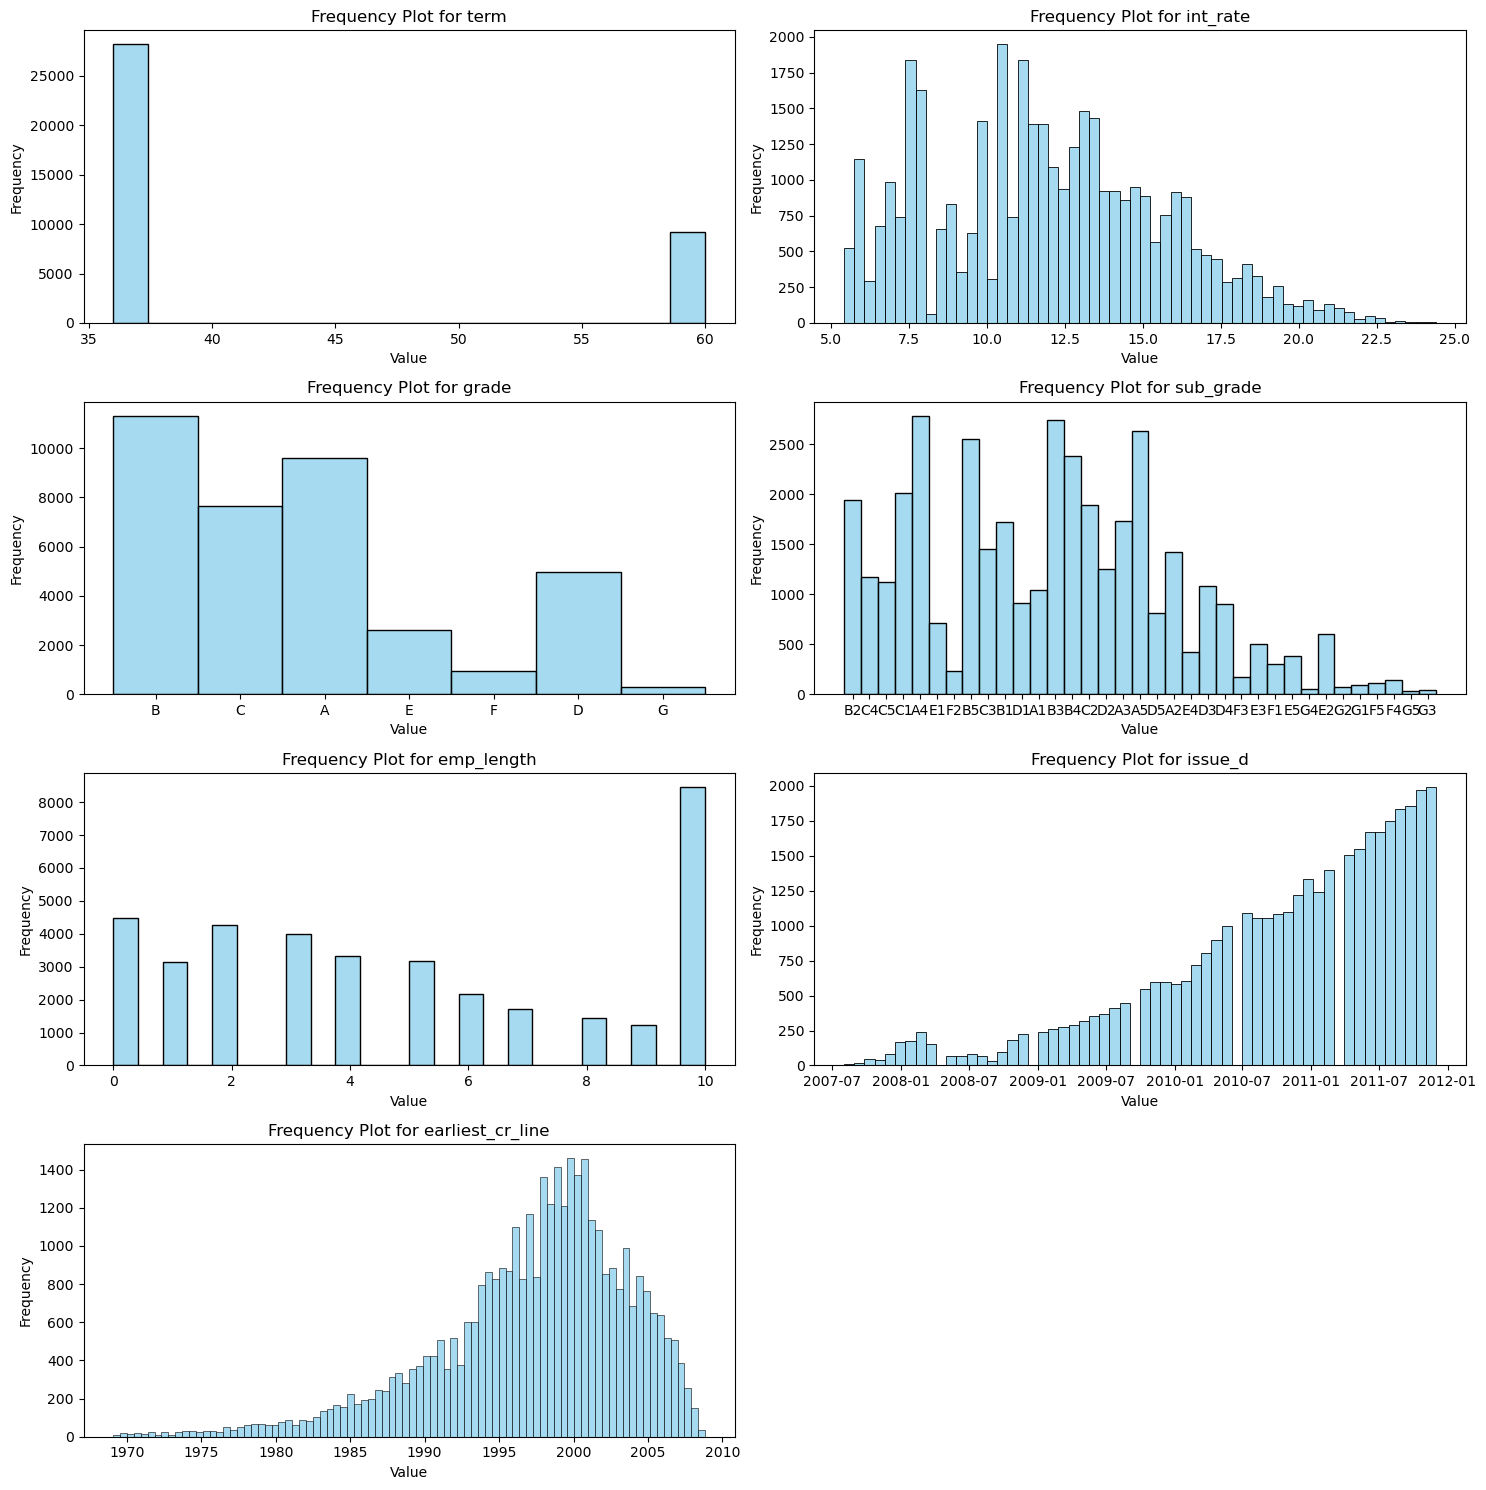

In [135]:
categorical_ordered = ['term', 'int_rate', 'grade', 'sub_grade', 'emp_length', 'issue_d', 'earliest_cr_line']
nrows = math.ceil(len(categorical_ordered) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 15))
for i, column in enumerate(categorical_ordered):
    # Frequency Plot
    row = i // ncols  # Calculate the row index
    col = i % ncols   # Calculate the column index
    sns.histplot(df_loan[column], kde=False, ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'Frequency Plot for {column}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')

# Remove empty subplots if the grid has more cells than needed
for j in range(len(categorical_ordered), nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

##### Insights that we can come up from above histogram:
- <b>Term plot(term)</b>: Maximum loans are duration of 3 years. Low duration mean low risk of default. Bank can approach to those customers who have either fully paid their loan or near the end of loan duration.
- <b>Interest Rate plot(int_rate)</b>: Maximum loans lies in intereset rate range 9 - 15%. It should be analyzed to what kind of customers interst rate lower than 9 or higher than 15 is offered. Instead of 9 or 15 we can consider quartile 1 and quartile 3 for comparison. May be higher interest rate was offered to customer having bad track record and lower interest rate to customers having good track record.
- <b>Grade plot(grade)</b>: Most of the A or B grade customers are assigned loan. This shows that bank is interested in alloting loans to only those customers having very low risk. It could be further analyzed that what common in customers having grade higher than B (C, D, E, F, or G) due to which bank provided them loan and can they be risk for further loans.
- <b>Sub-grade plot(sub_grade)</b>: As we can see that A4, B5 are alloted loan in large number than A1. One hypothesis is that out of all the customers applying for loan in bank, very few are of A1 as compare to A4, B5. Otherwise based on grade analysis bank would not reject A1 applications.
- <b>Employee Length(emp_length)</b>: Bank is preferring those customers more who have high employee length. However there are also customers which have low employee length. These customers could be potential risk for bank for current and future loans.
- <b>Issue Date(issue_d)</b>: With time loan applications are increasing. This could be due to various factors like economic conditions, bank policies, or changes in lending practices.
- <b>Earliest Credit Lines(earliest_cr_line)</b>: Most of the customers has credit history between 1990 to 2010.

#### Univariate Analysis for Quantitative Variables

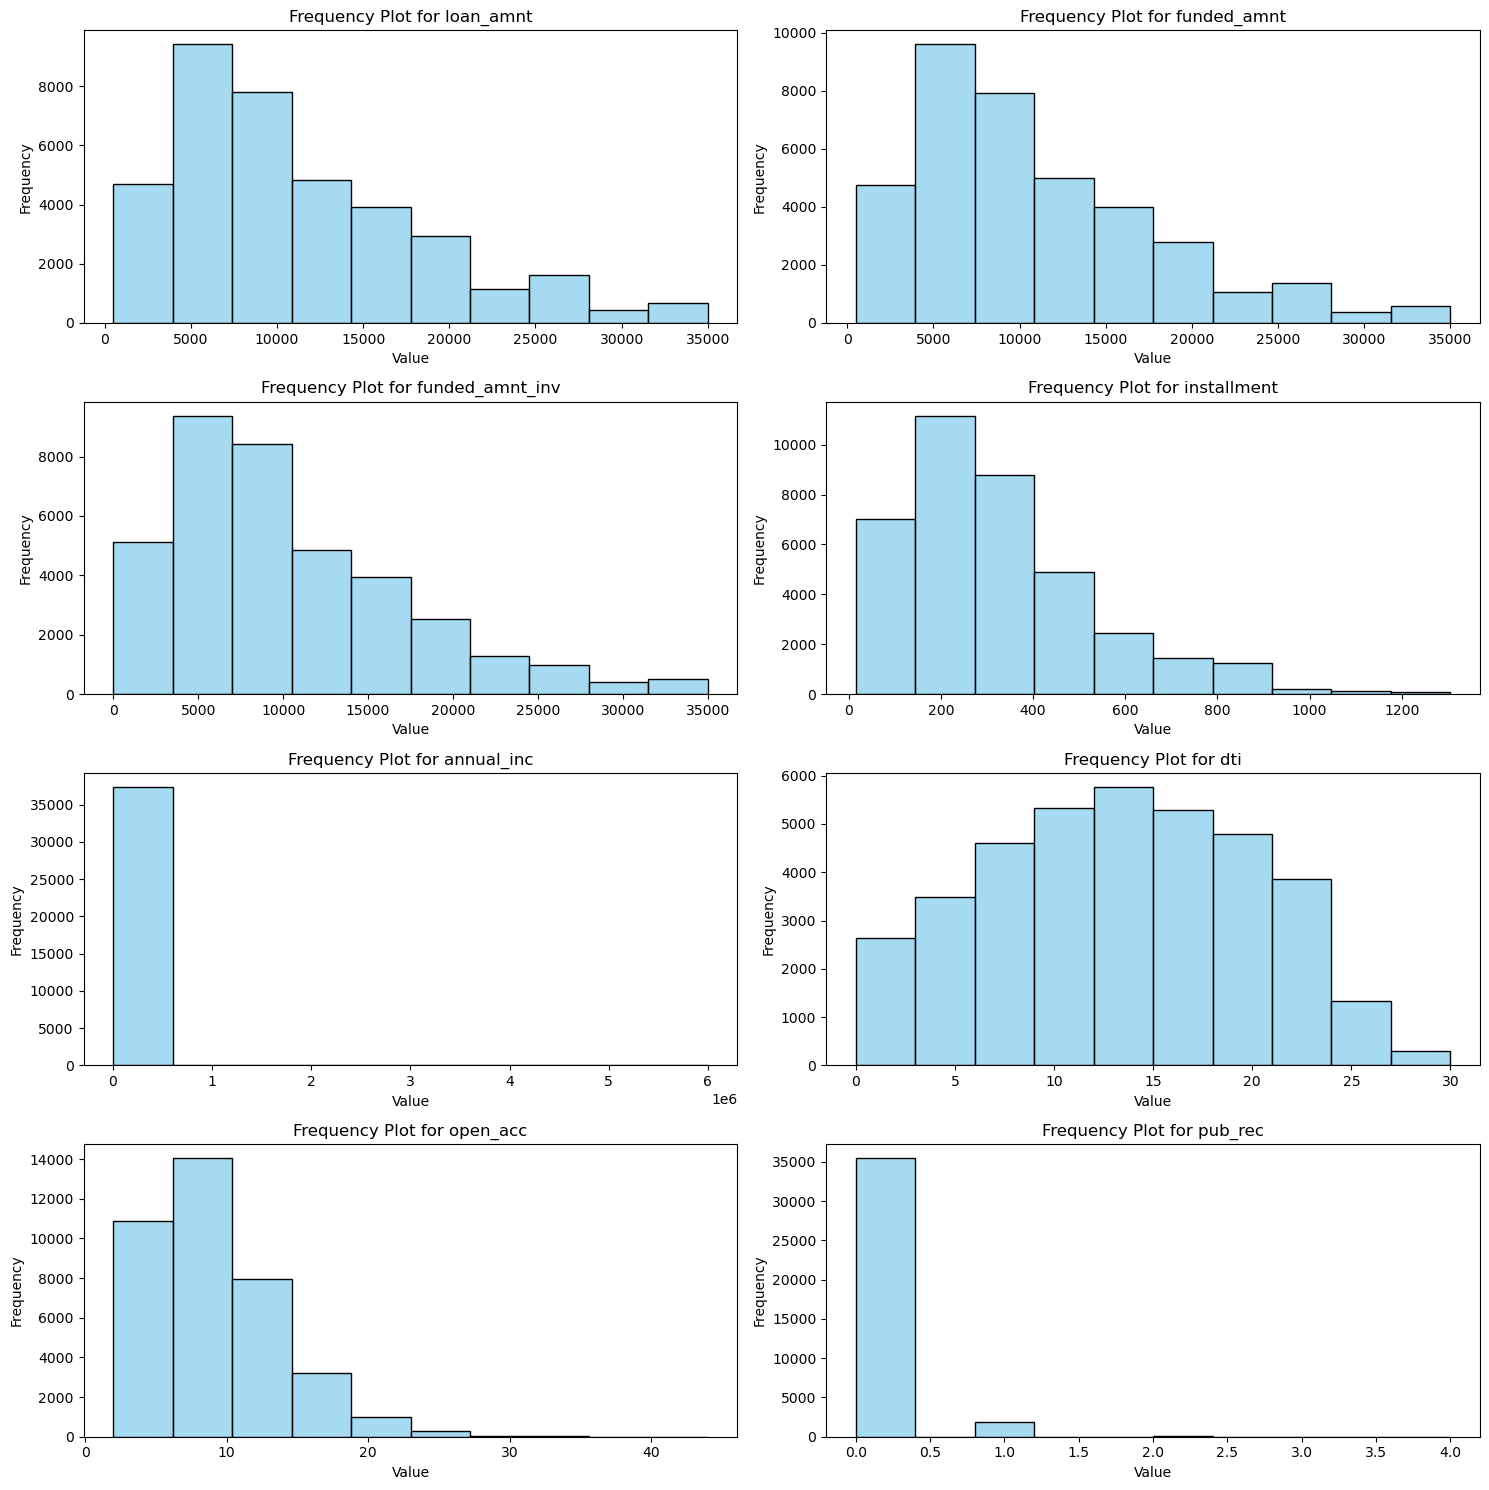

In [136]:
quantitative = ['loan_amnt',
'funded_amnt',
'funded_amnt_inv',
'installment',
'annual_inc',
'dti',
'open_acc',
'pub_rec']

ncols = 2
nrows = math.ceil(len(quantitative) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
for i, column in enumerate(quantitative):
    # Frequency Plot
    row = i // ncols  # Calculate the row index
    col = i % ncols   # Calculate the column index
    sns.histplot(df_loan[column], bins=10, kde=False, ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'Frequency Plot for {column}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')

# Remove empty subplots if the grid has more cells than needed
for j in range(len(quantitative), nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

##### Insights that we can come up from above histogram:
- <b>Loan Amount(loan_amnt)</b>: Most loans request falls between 5000-15000. High loan requests are less common. High loan amounts indicate greater risk.
- <b>Loan Amount Disbursed(funded_amnt)</b>: Follows a similar distribution as loan_amnt. This indicates efficient loan approval process as bank tends to fund amount close to loan amount requested.
- <b>Loan Amount Disbursed from Bank Investor(funded_amnt_inv)</b>: Follows a similar distribution as funded_amnt. This indicates investors has strong belief on bank and tends to fund amount close to loan amount requested.
- <b>Monthly Installment(installment)</b>: Most of the EMIs lies between 200-500. High EMIs might correlate with large loans and can impact borrower ability to repay.
- <b>Annual Income(annual_inc)</b>: Most customers contains income less than 200000 but there are <u>outliers</u> in data. 
- <b>Debt to Income Ratio(dti)</b>: Its value is less than 30 which indicates that bank grant loan to customers having low DTI as high DTI reflects high risk.
- <b>Open Credit Accounts(open_acc)</b>: Most customer has 1-15 opened credit accounts. More no. of credits represents more risk associated with customer.
- <b>Derrogatory Public Records(pub_rec)</b>: Almost all borrowers have zero public records, indicating good financial behavior. A small subset with 1 or more public records could be flagged as potentially higher risk.

##### Summary Metrics
<table border="1">
  <thead>
    <tr>
      <th>Quantitative Variables</th>
      <th>Mean</th>
      <th>Median (50 Percentile)</th>
      <th>25 Percentile</th>
      <th>75 Percentile</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>loan_amnt</td>
      <td>11304.94</td>
      <td>10000</td>
      <td>5600</td>
      <td>15000</td>
    </tr>
    <tr>
      <td>funded_amnt</td>
      <td>11030.01</td>
      <td>10000</td>
      <td>5500</td>
      <td>15000</td>
    </tr>
    <tr>
      <td>funded_amnt_inv</td>
      <td>10598.66</td>
      <td>9200</td>
      <td>5000</td>
      <td>14500</td>
    </tr>
    <tr>
      <td>installment</td>
      <td>326.11</td>
      <td>283.2</td>
      <td>168.9</td>
      <td>431.77</td>
    </tr>
    <tr>
      <td>annual_inc</td>
      <td>69278.08</td>
      <td>60000</td>
      <td>42000</td>
      <td>83000</td>
    </tr>
    <tr>
      <td>dti</td>
      <td>13.44</td>
      <td>13.54</td>
      <td>8.36</td>
      <td>18.69</td>
    </tr>
    <tr>
      <td>open_acc</td>
      <td>9.35</td>
      <td>9</td>
      <td>6</td>
      <td>12</td>
    </tr>
    <tr>
      <td>pub_rec</td>
      <td>0.05</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
  </tbody>
</table>d>3457.66</td>
    </tr>
    <tr>
      <td>pub_rec_bankruptcies</td>
      <td>0.04</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
  </tbody>
</table>


#### Bivariate Analysis

##### Target Variable will be loan status. Let's segment other categorical variables around loan status count and see that which variable is impacting loan status most.

##### Term

In [137]:
segmented_pivot_table('term', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
term,,,,,
60,2320,6922,9242,25.102792,74.897208
36,3063,25123,28186,10.867097,89.132903


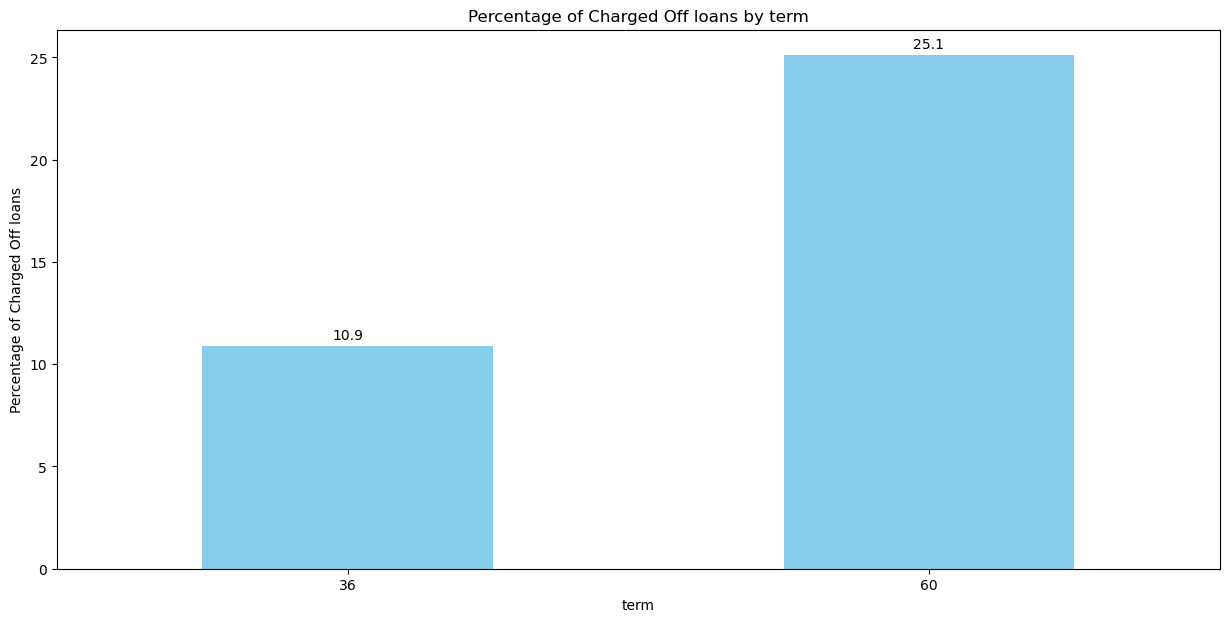

In [138]:
create_bivariate_chart(df_loan, 'term')

<b>From the above pivot table it is clear that customers who are taking 5 year term loan are defaulting most. Thus term could be a <u>DRIVING VARIABLE</u><b>

##### int_rate

<Axes: >

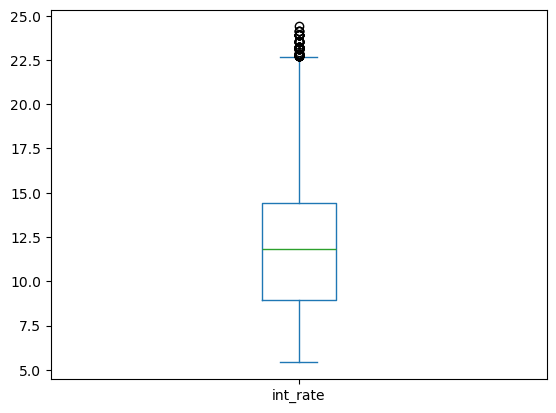

In [139]:
# First let's filter out outliers from int_rate
df_loan['int_rate'].plot.box()

<Axes: >

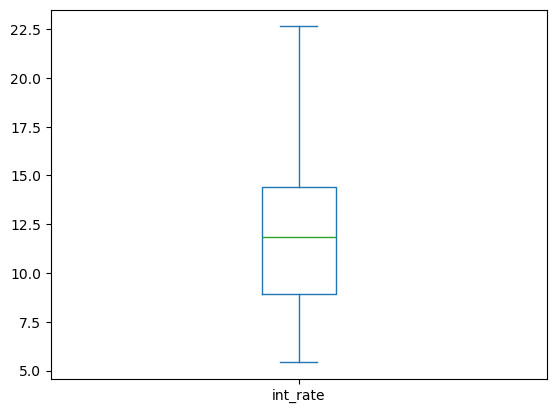

In [140]:
# As there are outliers in int_rate, so let's remove them
df_loan = remove_outliers('int_rate')
df_loan['int_rate'].plot.box()

In [141]:
# Let's divide interset rate in 5 categories V.low for 0-5%, low for 5-10%, medium for 10-15%, high for 15-20% and V. high for 20-25%
# DERIVED METRIC
df_loan['int_rate_bucket'] = pd.qcut(df_loan['int_rate'], q=[0,0.2,0.4,0.6,0.8,1], labels=['V. low', 'low', 'medium', 'high', 'V. high'])
df_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,issue_d,loan_status,purpose,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,int_rate_bucket
0,5000,5000,4975.0,36,10.65,162.87,B,B2,10,RENT,...,2011-12-01,Fully Paid,credit_card,860xx,AZ,27.65,1985-01-01,3,0,low
1,2500,2500,2500.0,60,15.27,59.83,C,C4,0,RENT,...,2011-12-01,Charged Off,car,309xx,GA,1.00,1999-04-01,3,0,V. high
2,2400,2400,2400.0,36,15.96,84.33,C,C5,10,RENT,...,2011-12-01,Fully Paid,small_business,606xx,IL,8.72,2001-11-01,2,0,V. high
3,10000,10000,10000.0,36,13.49,339.31,C,C1,10,RENT,...,2011-12-01,Fully Paid,other,917xx,CA,20.00,1996-02-01,10,0,high
5,5000,5000,5000.0,36,7.90,156.46,A,A4,3,RENT,...,2011-12-01,Fully Paid,wedding,852xx,AZ,11.20,2004-11-01,9,0,V. low


In [142]:
segmented_pivot_table('int_rate_bucket', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
int_rate_bucket,,,,,
V. high,1928,5510,7438,25.920946,74.079054
high,1259,6219,7478,16.836052,83.163948
medium,976,5809,6785,14.384672,85.615328
low,802,7233,8035,9.981332,90.018668
V. low,389,7239,7628,5.099633,94.900367


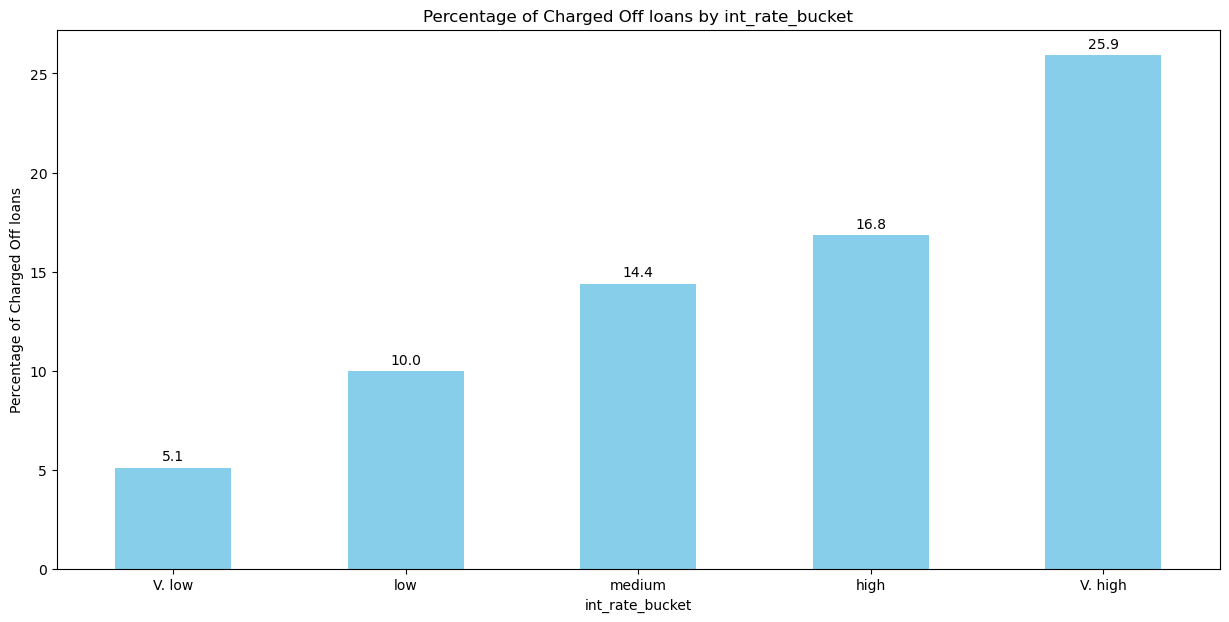

In [143]:
create_bivariate_chart(df_loan, 'int_rate_bucket')

<b>From the above table it is clear that as interest rate is increasing, chances of default is also increasing. Loans at high interest rate are vulnerable of default. Thus int_rate can be a <u>DRIVING VARIABLE</u></b>

##### funded_amnt
<p>NOTE: funded_amnt will show same characterstic as of loan_amnt and funded_amnt_inv. Because funded_amnt is almost same as of loan_amnt</p>

<Axes: >

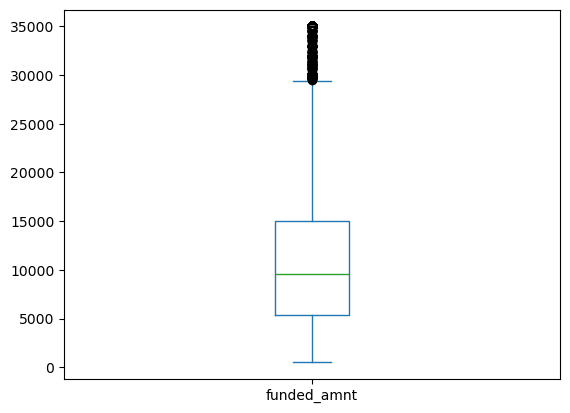

In [144]:
df_loan['funded_amnt'].plot.box()

<Axes: >

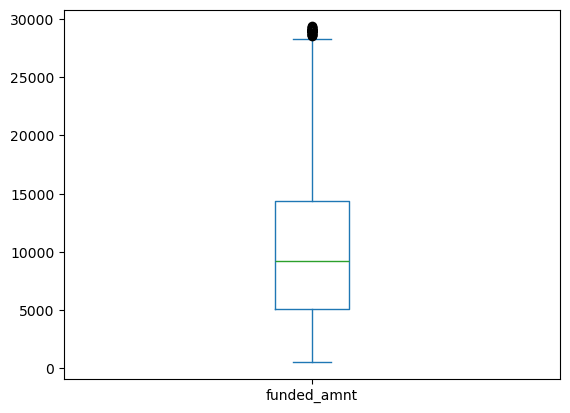

In [145]:
# As there are outliers in funded_amnt, so let's remove them
df_loan = remove_outliers('funded_amnt')
df_loan['funded_amnt'].plot.box()

In [146]:
# Let's divide funded_amnt in 5 quartiles V.low, low, medium, high and V. high
# DERIVED METRIC
df_loan['funded_amnt_bucket'] = pd.qcut(df_loan['funded_amnt'], q=[0,0.2,0.4,0.6,0.8,1], labels=['V. low', 'low', 'medium', 'high', 'V. high'])
df_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,loan_status,purpose,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,int_rate_bucket,funded_amnt_bucket
0,5000,5000,4975.0,36,10.65,162.87,B,B2,10,RENT,...,Fully Paid,credit_card,860xx,AZ,27.65,1985-01-01,3,0,low,V. low
1,2500,2500,2500.0,60,15.27,59.83,C,C4,0,RENT,...,Charged Off,car,309xx,GA,1.00,1999-04-01,3,0,V. high,V. low
2,2400,2400,2400.0,36,15.96,84.33,C,C5,10,RENT,...,Fully Paid,small_business,606xx,IL,8.72,2001-11-01,2,0,V. high,V. low
3,10000,10000,10000.0,36,13.49,339.31,C,C1,10,RENT,...,Fully Paid,other,917xx,CA,20.00,1996-02-01,10,0,high,medium
5,5000,5000,5000.0,36,7.90,156.46,A,A4,3,RENT,...,Fully Paid,wedding,852xx,AZ,11.20,2004-11-01,9,0,V. low,V. low


In [147]:
segmented_pivot_table('funded_amnt_bucket', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
funded_amnt_bucket,,,,,
V. high,1291,5778,7069,18.262838,81.737162
V. low,1232,7851,9083,13.563801,86.436199
medium,956,6093,7049,13.562207,86.437793
high,1012,6479,7491,13.509545,86.490455
low,670,5109,5779,11.593701,88.406299


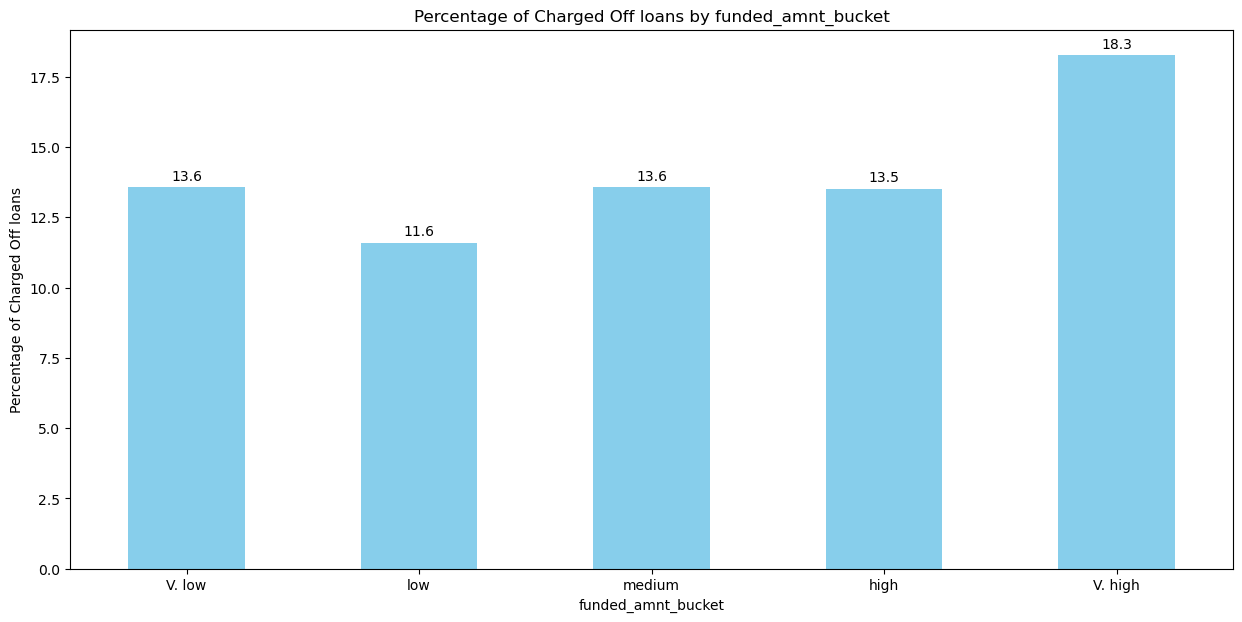

In [148]:
create_bivariate_chart(df_loan, 'funded_amnt_bucket')

<b>From the above table, we can read that apart from very high loan amount, for other segment of loan amounts charge off percentage is approximately same. Even for very high loan as well percentage difference could be just because of <u>Randomness</u>. Thus funded_amnt or loan_amnt or funded_amnt_inv <u>cannot</u> be considered driving variables</b>

##### Installment

<Axes: >

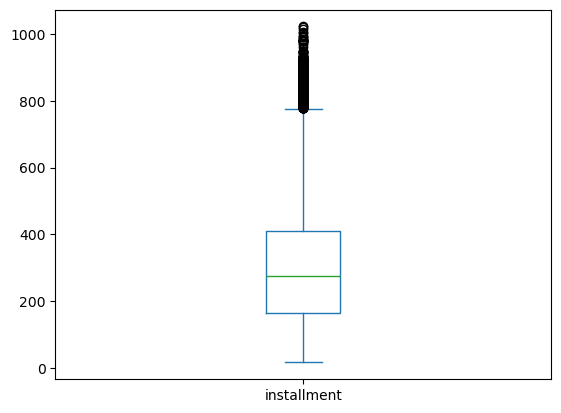

In [149]:
df_loan['installment'].plot.box()

<Axes: >

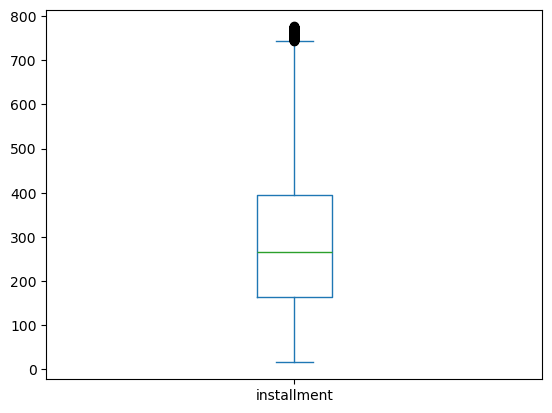

In [150]:
# As there are outliers in installment, so let's remove them
df_loan = remove_outliers('installment')
df_loan['installment'].plot.box()

In [151]:
# Let's divide installment in 5 quartiles V.low, low, medium, high and V. high
# DERIVED METRIC
df_loan['installment_bucket'] = pd.qcut(df_loan['installment'], q=[0,0.2,0.4,0.6,0.8,1], labels=['V. low', 'low', 'medium', 'high', 'V. high'])
df_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,purpose,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,int_rate_bucket,funded_amnt_bucket,installment_bucket
0,5000,5000,4975.0,36,10.65,162.87,B,B2,10,RENT,...,credit_card,860xx,AZ,27.65,1985-01-01,3,0,low,V. low,low
1,2500,2500,2500.0,60,15.27,59.83,C,C4,0,RENT,...,car,309xx,GA,1.00,1999-04-01,3,0,V. high,V. low,V. low
2,2400,2400,2400.0,36,15.96,84.33,C,C5,10,RENT,...,small_business,606xx,IL,8.72,2001-11-01,2,0,V. high,V. low,V. low
3,10000,10000,10000.0,36,13.49,339.31,C,C1,10,RENT,...,other,917xx,CA,20.00,1996-02-01,10,0,high,medium,high
5,5000,5000,5000.0,36,7.90,156.46,A,A4,3,RENT,...,wedding,852xx,AZ,11.20,2004-11-01,9,0,V. low,V. low,low


In [152]:
segmented_pivot_table('installment_bucket', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
installment_bucket,,,,,
V. high,1109,5970,7079,15.666055,84.333945
high,1029,6053,7082,14.529794,85.470206
V. low,997,6085,7082,14.077944,85.922056
medium,958,6117,7075,13.540636,86.459364
low,918,6170,7088,12.951467,87.048533


<b>From the above table, we can read that apart from very high installment amount, for other segment of installment, charge off percentage is approximately same. Even for very high installment as well percentage difference could be just because of <u>Randomness</u>. Thus installment <u>cannot</u> be considered driving variables</b>

##### grade

In [153]:
segmented_pivot_table('grade', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
grade,,,,,
G,64,127,191,33.507853,66.492147
F,248,541,789,31.432193,68.567807
E,619,1694,2313,26.761781,73.238219
D,1010,3548,4558,22.158842,77.841158
C,1233,6107,7340,16.798365,83.201635
B,1286,9446,10732,11.982855,88.017145
A,551,8932,9483,5.810398,94.189602


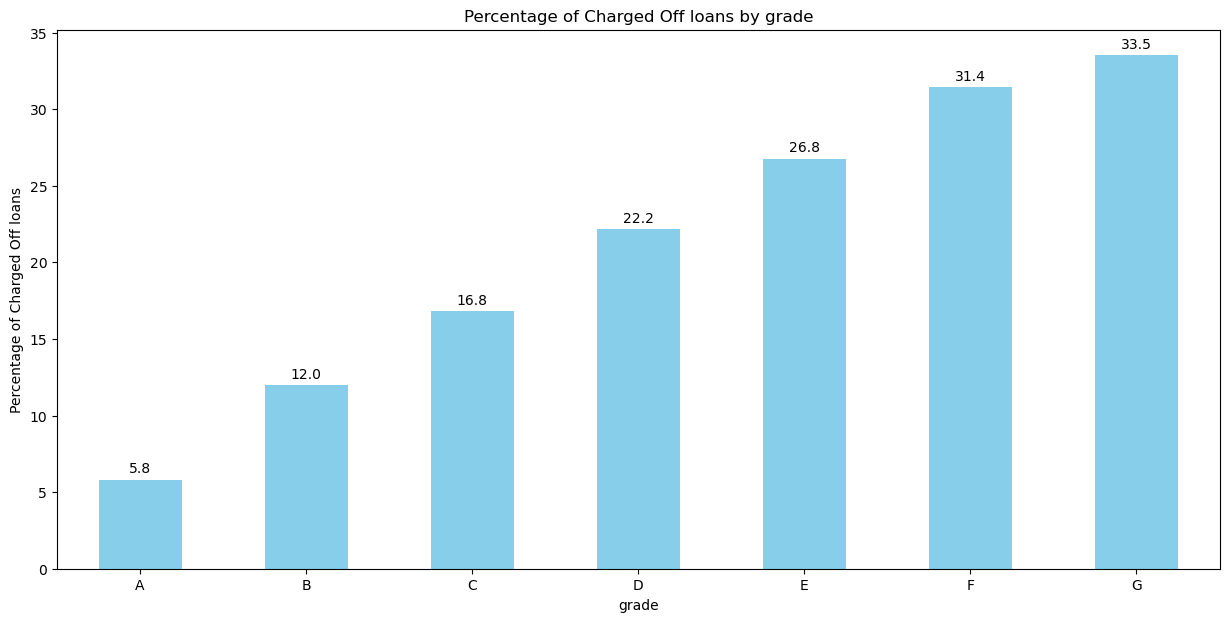

In [154]:
# Bivariate analysis of Grade and Loan Status
create_bivariate_chart(df_loan, 'grade')

<b>From the above table it is clear that as grade is shifting from A to G, chances of default are also increasing. Loans to high grade customer are risky. Thus grade can be a <u>DRIVING VARIABLE</u></b>

##### sub_grade

In [155]:
segmented_pivot_table('sub_grade', df_loan[df_loan['grade'] == 'A'])

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
sub_grade,,,,,
A5,207,2380,2587,8.001546,91.998454
A4,165,2549,2714,6.079587,93.920413
A3,88,1637,1725,5.101449,94.898551
A2,67,1345,1412,4.745042,95.254958
A1,24,1021,1045,2.296651,97.703349


<b>Charge off percentage is increasing as sub_grade shift from A1 to A5. Difference is very small and overally percentage is very small as well. This difference could be due to <u>Randomness</u>. No useful insight can be drawn from this.</b>

In [156]:
segmented_pivot_table('sub_grade', df_loan[df_loan['grade'] == 'B'])

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
sub_grade,,,,,
B5,328,2078,2406,13.632585,86.367415
B4,299,1948,2247,13.306631,86.693369
B3,303,2241,2544,11.910377,88.089623
B2,203,1655,1858,10.925727,89.074273
B1,153,1524,1677,9.123435,90.876565


<b>Charge off percentage is increasing as sub_grade shift from B1 to B5. Difference is very small. This difference could be due to <u>Randomness</u>. No useful insight can be drawn from this.</b>

In [157]:
segmented_pivot_table('sub_grade', df_loan[df_loan['grade'] == 'C'])

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
sub_grade,,,,,
C5,191,882,1073,17.800559,82.199441
C3,249,1166,1415,17.597173,82.402827
C4,197,940,1137,17.326297,82.673703
C2,295,1521,1816,16.244493,83.755507
C1,301,1598,1899,15.850448,84.149552


<b>Charge off percentage is increasing as sub_grade shift from C1 to C3. For C3 to C5 it is almost same. Difference is very small. This difference could be due to <u>Randomness</u>. No useful insight can be drawn from this.</b>

In [158]:
segmented_pivot_table('sub_grade', df_loan[df_loan['grade'] == 'D'])

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
sub_grade,,,,,
D5,190,539,729,26.063100,73.936900
D4,196,624,820,23.902439,76.097561
D3,224,767,991,22.603431,77.396569
D2,249,921,1170,21.282051,78.717949
D1,151,697,848,17.806604,82.193396


<b>Charge off percentage is increasing as sub_grade shift from D1 to D3. For D3 to D4 it is almost same. For D5 it is slightly high. Difference is very small. This difference could be due to <u>Randomness</u>. No useful insight can be drawn from this.</b>

In [159]:
segmented_pivot_table('sub_grade', df_loan[df_loan['grade'] == 'E'])

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
sub_grade,,,,,
E4,111,259,370,30.000000,70.000000
E5,90,228,318,28.301887,71.698113
E2,146,397,543,26.887661,73.112339
E1,165,469,634,26.025237,73.974763
E3,107,341,448,23.883929,76.116071


<b>There is no pattern in Charge off percentage as sub_grade shift from E1 to E5.<b> 

In [160]:
segmented_pivot_table('sub_grade', df_loan[df_loan['grade'] == 'F'])

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
sub_grade,,,,,
F5,40,43,83,48.192771,51.807229
F4,42,84,126,33.333333,66.666667
F2,59,137,196,30.102041,69.897959
F3,41,97,138,29.710145,70.289855
F1,66,180,246,26.829268,73.170732


<b>Charge off percentage is increasing sub_grade shift from F1 to F5. F4 and F5 are most vulnerable. For F5 grade customers approximatly 50% of loans are charged off.</b>

In [161]:
segmented_pivot_table('sub_grade', df_loan[df_loan['grade'] == 'G'])

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
sub_grade,,,,,
G5,7,11,18,38.888889,61.111111
G2,20,35,55,36.363636,63.636364
G3,10,19,29,34.482759,65.517241
G1,19,42,61,31.147541,68.852459
G4,8,20,28,28.571429,71.428571


<b>There is no pattern in Charge off percentage as sub_grade shift from G1 to G5. But G2 G3 grade although lower grade of G series are highly vulnerable</b>

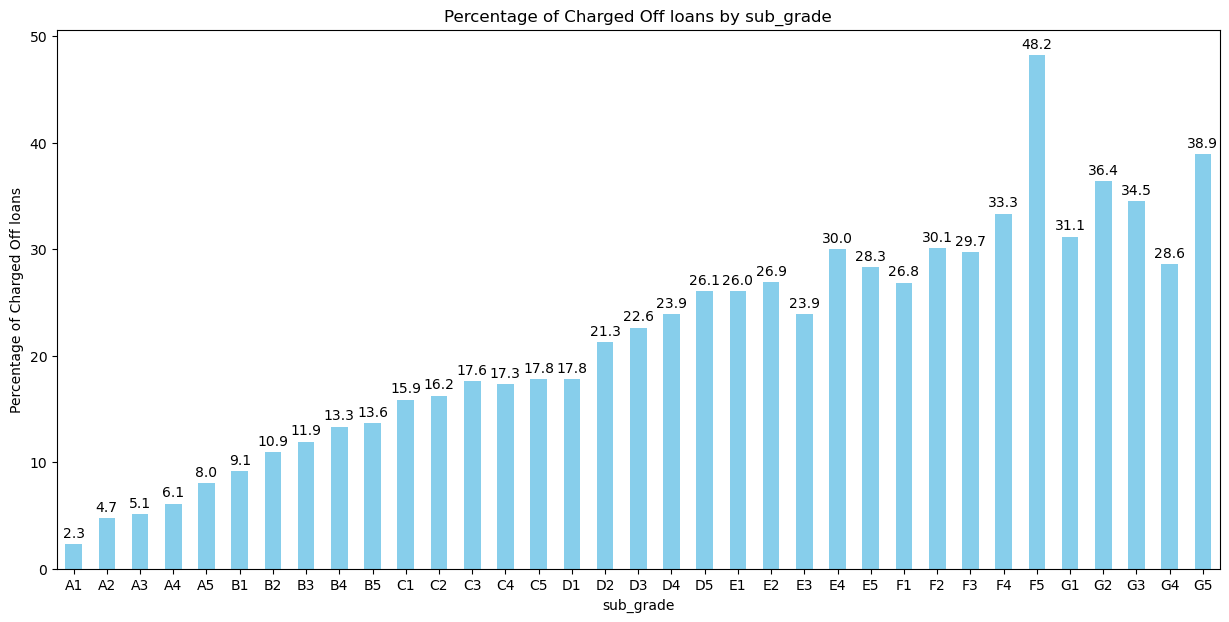

In [162]:
create_bivariate_chart(df_loan, 'sub_grade')

<b>In General we see that there is no specific trend in sub_grade. So it <u>cannot</u> be driving variable.</b>

##### emp_length

In [163]:
segmented_pivot_table('emp_length', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
emp_length,,,,,
7,246,1358,1604,15.336658,84.663342
10,1192,6610,7802,15.278134,84.721866
8,192,1142,1334,14.392804,85.607196
1,432,2589,3021,14.299901,85.700099
5,424,2597,3021,14.035088,85.964912
6,288,1764,2052,14.035088,85.964912
0,601,3710,4311,13.941081,86.058919
3,521,3318,3839,13.571243,86.428757
4,430,2742,3172,13.556116,86.443884


<b>As we see that there is no specific trend in emp_length. So it <u>cannot</u> be driving variable.</b>

##### home_ownership

In [164]:
segmented_pivot_table('home_ownership', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
home_ownership,,,,,
OTHER,17,76,93,18.279570,81.720430
RENT,2613,14782,17395,15.021558,84.978442
OWN,376,2250,2626,14.318355,85.681645
MORTGAGE,2005,13287,15292,13.111431,86.888569


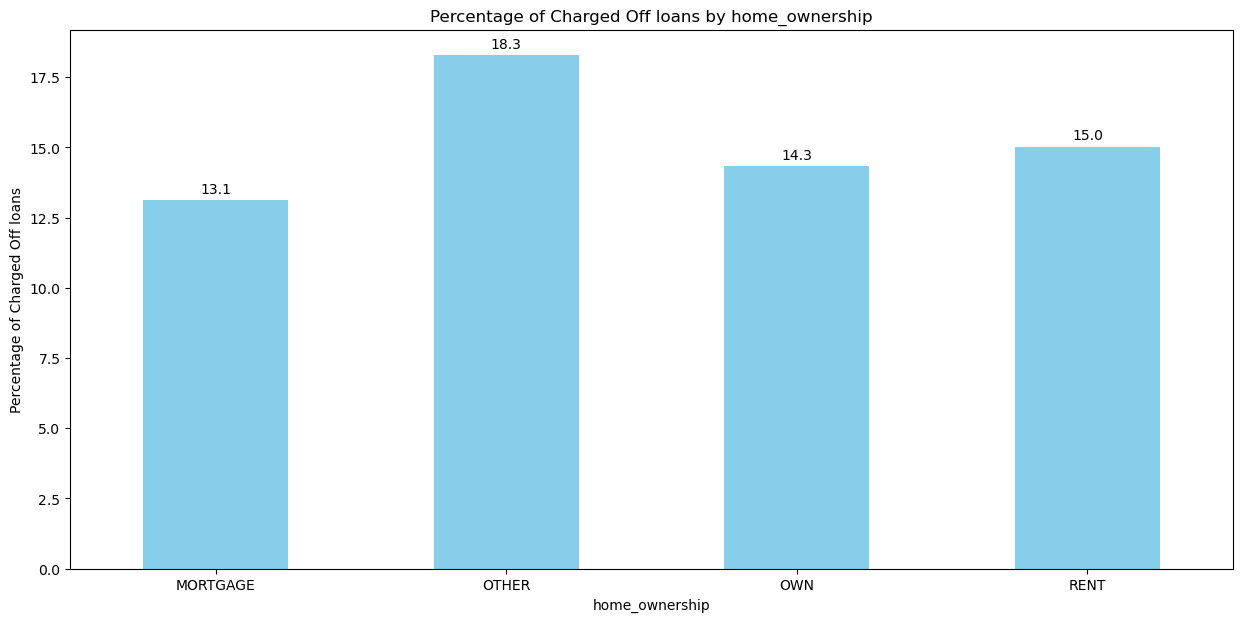

In [165]:
# Bivariate analysis of Home Ownership and Loan Status
create_bivariate_chart(df_loan, 'home_ownership')

<b>From above analysis we can see that customers who have OTHER ownership are getting charged off mostly. After that RENT, OWN, and in last MORTGAGE. MORTGAGE become further less risky if asset is mortgaged with bank. This column could be a <u>DRIVING VARIABLE</u></b>

##### annual_inc

<Axes: >

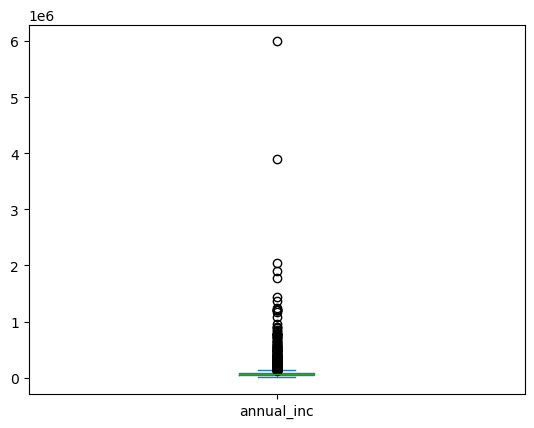

In [166]:
df_loan['annual_inc'].plot.box()

<Axes: >

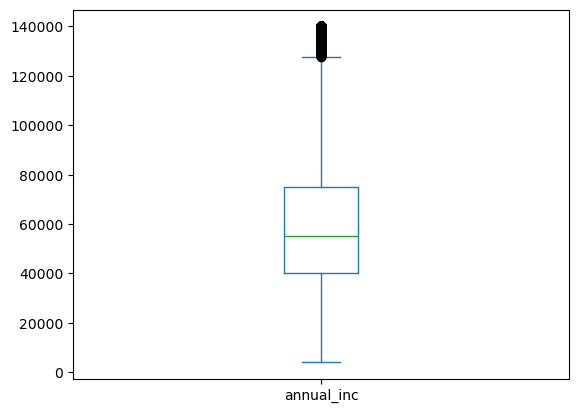

In [167]:
# As there are outliers in annual_inc, so let's remove them
df_loan = remove_outliers('annual_inc')
df_loan['annual_inc'].plot.box()

In [168]:
# Let's divide funded_amnt in 5 quartiles V.low, low, medium, high and V. high
# DERIVED METRIC
df_loan['annual_inc_bucket'] = pd.qcut(df_loan['annual_inc'], q=[0,0.2,0.4,0.6,0.8,1], labels=['V. low', 'low', 'medium', 'high', 'V. high'])
df_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,int_rate_bucket,funded_amnt_bucket,installment_bucket,annual_inc_bucket
0,5000,5000,4975.0,36,10.65,162.87,B,B2,10,RENT,...,860xx,AZ,27.65,1985-01-01,3,0,low,V. low,low,V. low
1,2500,2500,2500.0,60,15.27,59.83,C,C4,0,RENT,...,309xx,GA,1.00,1999-04-01,3,0,V. high,V. low,V. low,V. low
2,2400,2400,2400.0,36,15.96,84.33,C,C5,10,RENT,...,606xx,IL,8.72,2001-11-01,2,0,V. high,V. low,V. low,V. low
3,10000,10000,10000.0,36,13.49,339.31,C,C1,10,RENT,...,917xx,CA,20.00,1996-02-01,10,0,high,medium,high,low
5,5000,5000,5000.0,36,7.90,156.46,A,A4,3,RENT,...,852xx,AZ,11.20,2004-11-01,9,0,V. low,V. low,low,V. low


In [169]:
segmented_pivot_table('annual_inc_bucket', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
annual_inc_bucket,,,,,
V. low,1225,5618,6843,17.901505,82.098495
low,1196,6550,7746,15.440227,84.559773
medium,871,4993,5864,14.853342,85.146658
high,872,5860,6732,12.953060,87.046940
V. high,702,6094,6796,10.329606,89.670394


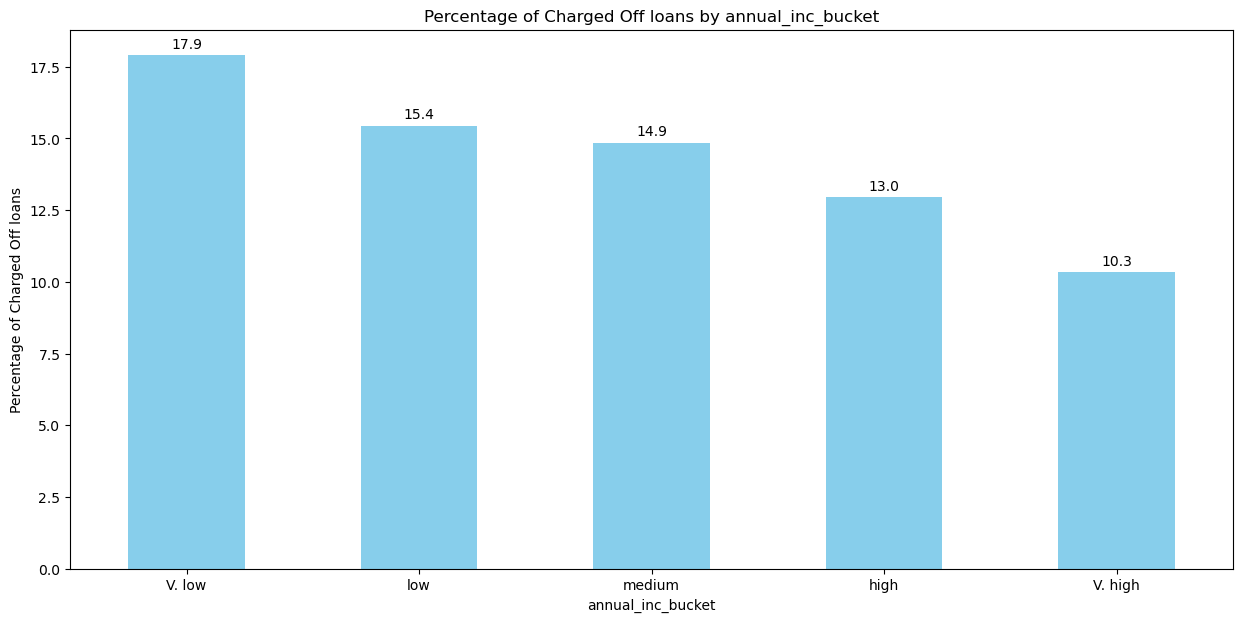

In [170]:
create_bivariate_chart(df_loan, 'annual_inc_bucket', 0)

<b>From above analysis we can say that less income customer loans are likely of charge off. As income is reducing charge off percentage is increasing. This could be the <u>DRIVING VARIABLE</u>.</b>

##### verification_status

In [171]:
segmented_pivot_table('verification_status', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
verification_status,,,,,
Verified,1610,7993,9603,16.765594,83.234406
Source Verified,1299,7507,8806,14.751306,85.248694
Not Verified,1957,13615,15572,12.567429,87.432571


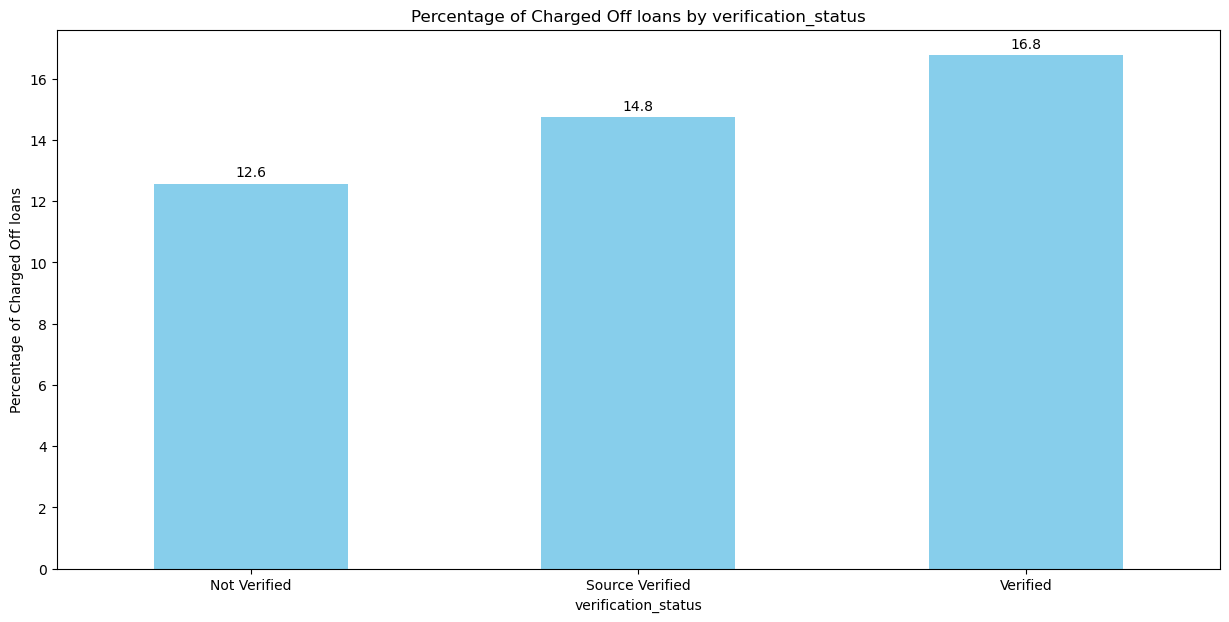

In [172]:
create_bivariate_chart(df_loan, 'verification_status')

<b>Although verified customers look more risky but we <u>cannot</u> consider it as driving variable as there are chances that system has more number of verified customer than not verified. 
High no. of charged off verified customers shows that the Lending Club needs to visit the verification process. </b>

##### issue_d

In [173]:
# Let's extract month and year from issue_d and see trend in it
# DERIVED METRIC
df_loan['issue_month'] = df_loan['issue_d'].dt.month
df_loan['issue_year'] = df_loan['issue_d'].dt.year
df_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,dti,earliest_cr_line,open_acc,pub_rec,int_rate_bucket,funded_amnt_bucket,installment_bucket,annual_inc_bucket,issue_month,issue_year
0,5000,5000,4975.0,36,10.65,162.87,B,B2,10,RENT,...,27.65,1985-01-01,3,0,low,V. low,low,V. low,12,2011
1,2500,2500,2500.0,60,15.27,59.83,C,C4,0,RENT,...,1.00,1999-04-01,3,0,V. high,V. low,V. low,V. low,12,2011
2,2400,2400,2400.0,36,15.96,84.33,C,C5,10,RENT,...,8.72,2001-11-01,2,0,V. high,V. low,V. low,V. low,12,2011
3,10000,10000,10000.0,36,13.49,339.31,C,C1,10,RENT,...,20.00,1996-02-01,10,0,high,medium,high,low,12,2011
5,5000,5000,5000.0,36,7.90,156.46,A,A4,3,RENT,...,11.20,2004-11-01,9,0,V. low,V. low,low,V. low,12,2011


In [174]:
segmented_pivot_table('issue_month', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
issue_month,,,,,
9,490,2573,3063,15.997388,84.002612
12,594,3122,3716,15.984930,84.015070
5,407,2205,2612,15.581930,84.418070
6,421,2415,2836,14.844852,85.155148
10,470,2738,3208,14.650873,85.349127
11,502,3008,3510,14.301994,85.698006
7,424,2548,2972,14.266487,85.733513
8,408,2578,2986,13.663764,86.336236
1,285,1845,2130,13.380282,86.619718


In [175]:
segmented_pivot_table('issue_year', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
issue_year,,,,,
2007,32,139,171,18.713450,81.286550
2011,2765,14946,17711,15.611767,84.388233
2008,221,1227,1448,15.262431,84.737569
2010,1309,9017,10326,12.676738,87.323262
2009,539,3786,4325,12.462428,87.537572


<b>Issue Month and Year are not showing any trend that affect charge off percentage. So they <u>cannot</u> be driving variables. But some insight this data gives is that bank has improved its loan process from 2007 to 2011. In 2007 charge off percentage was highest. However 2011 is also significant high.</b>

##### purpose

In [176]:
segmented_pivot_table('purpose', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
purpose,,,,,
small_business,387,1039,1426,27.138850,72.861150
renewable_energy,16,66,82,19.512195,80.487805
educational,49,247,296,16.554054,83.445946
house,50,254,304,16.447368,83.552632
other,550,2908,3458,15.905147,84.094853
medical,97,514,611,15.875614,84.124386
moving,82,437,519,15.799615,84.200385
debt_consolidation,2413,13575,15988,15.092569,84.907431
vacation,49,284,333,14.714715,85.285285


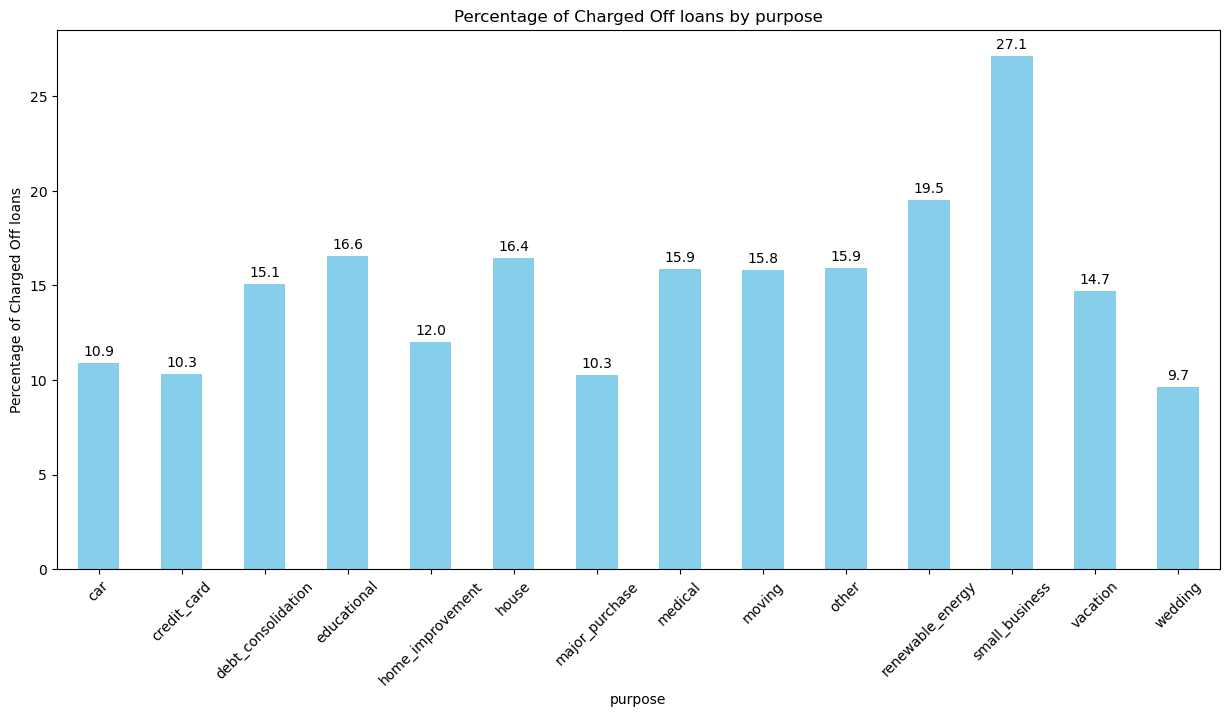

In [177]:
# 45 is rotation of labels
create_bivariate_chart(df_loan, 'purpose', 45)

<b>As we can see small business loans have high tendency to get charged off, whereas wedding loans have lowest tendency to get charged off. This could be a <u>DRIVING VARIABLE</u></b>

##### zip_code

In [178]:
segmented_pivot_table('zip_code', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
zip_code,,,,,
999xx,1,0,1,100.0,0.0
094xx,1,0,1,100.0,0.0
373xx,1,0,1,100.0,0.0
663xx,1,0,1,100.0,0.0
669xx,1,0,1,100.0,0.0
...,...,...,...,...,...
379xx,0,3,3,0.0,100.0
712xx,0,12,12,0.0,100.0
188xx,0,5,5,0.0,100.0


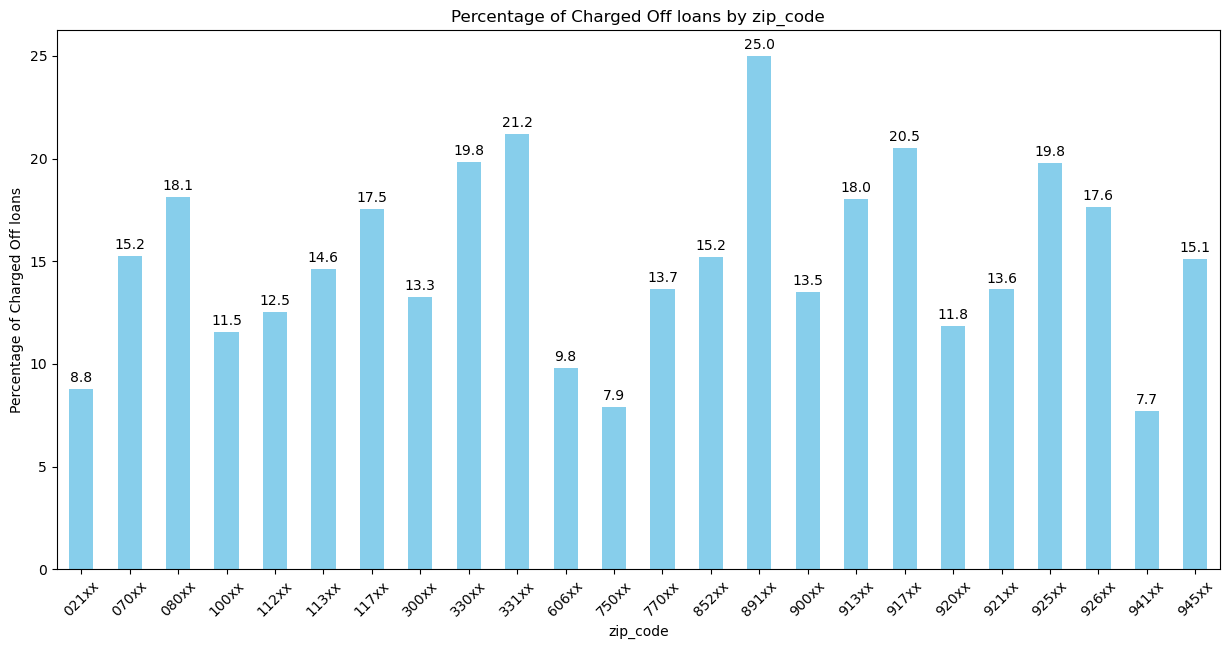

In [179]:
# fetch all the recods that contain zips that have more than 200 applications
# We have taken 200 applications in order to get a clear understanding of the zip code data
# since many zip codes we having as few as 1 or 2 applications and all of them were marked as deafulted
zip_code = df_loan['zip_code'].value_counts()
zip_code = zip_code[zip_code > 200]
zip_code = zip_code.index
df_loan_zip_code = df_loan[df_loan['zip_code'].isin(zip_code)]
create_bivariate_chart(df_loan_zip_code, 'zip_code', 45)

<b>There is no trend in zip code. It <u>cannot</u> be driving variable. However we can see that certain zip codes such as 891xx has high charge off. We can further drill down to find the root cause. </b>

##### addr_state

In [180]:
segmented_pivot_table('addr_state', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
addr_state,,,,,
NE,1,2,3,33.333333,66.666667
NV,89,333,422,21.090047,78.909953
ID,1,4,5,20.000000,80.000000
AK,13,53,66,19.696970,80.303030
HI,28,122,150,18.666667,81.333333
SD,11,48,59,18.644068,81.355932
FL,433,2026,2459,17.608784,82.391216
NM,29,140,169,17.159763,82.840237
MO,101,498,599,16.861436,83.138564


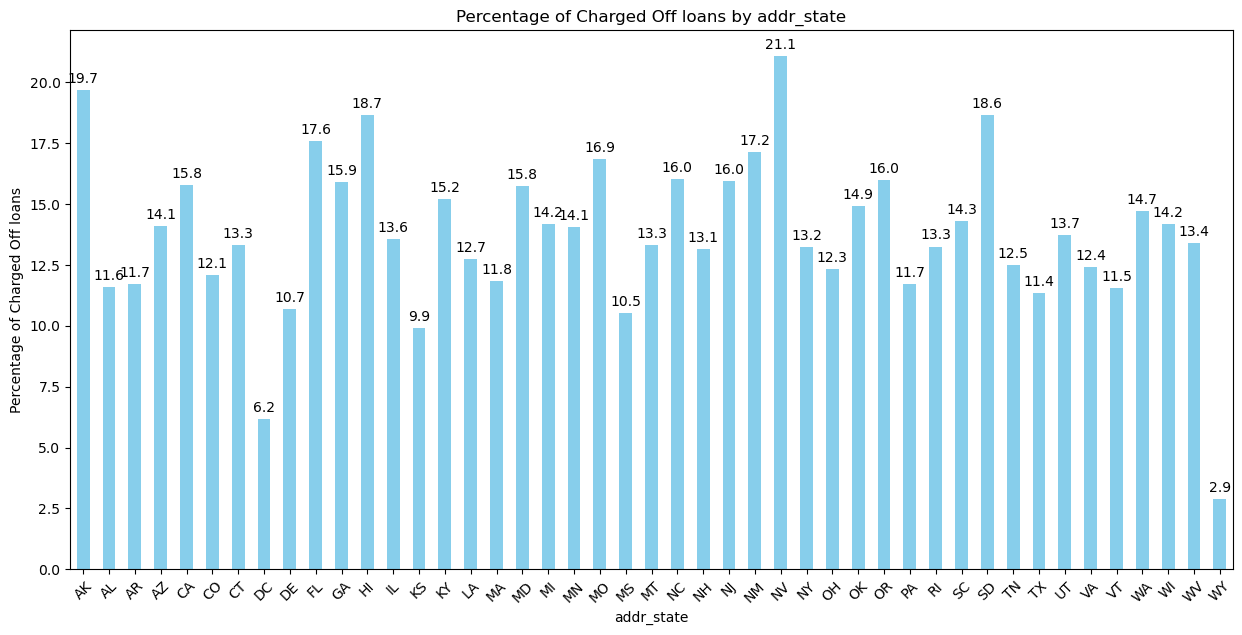

In [181]:
# fetch all the recods that contain states that have more than 10 applications
# We have taken 10 applications in order to get a clear understanding of the addr state data
# since many addr state we having as few as 1 or 2 applications and all of them were marked as deafulted
addr_state = df_loan['addr_state'].value_counts()
addr_state = addr_state[addr_state > 10]
addr_state = addr_state.index
df_loan_addr_state = df_loan[df_loan['addr_state'].isin(addr_state)]
create_bivariate_chart(df_loan_addr_state, 'addr_state', 45)

<b>There is no trend in addr_state. It cannot be driving variable. However there are some insights such as Customers belonging from the states of NV has the higher (21.3%) chance of defaulting. Other noteworthy states are AK and SD</b>

##### dti

<Axes: >

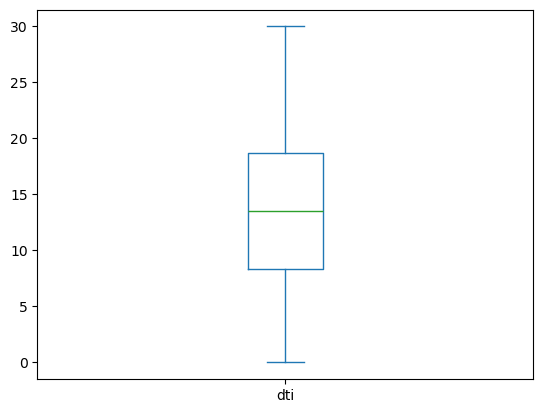

In [182]:
# No Outliers
df_loan['dti'].plot.box()

In [183]:
# Let's divide dti in 5 quartiles V.low, low, medium, high and V. high
# DERIVED METRIC
df_loan['dti_bucket'] = pd.qcut(df_loan['dti'], q=[0,0.2,0.4,0.6,0.8,1], labels=['V. low', 'low', 'medium', 'high', 'V. high'])
df_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,earliest_cr_line,open_acc,pub_rec,int_rate_bucket,funded_amnt_bucket,installment_bucket,annual_inc_bucket,issue_month,issue_year,dti_bucket
0,5000,5000,4975.0,36,10.65,162.87,B,B2,10,RENT,...,1985-01-01,3,0,low,V. low,low,V. low,12,2011,V. high
1,2500,2500,2500.0,60,15.27,59.83,C,C4,0,RENT,...,1999-04-01,3,0,V. high,V. low,V. low,V. low,12,2011,V. low
2,2400,2400,2400.0,36,15.96,84.33,C,C5,10,RENT,...,2001-11-01,2,0,V. high,V. low,V. low,V. low,12,2011,low
3,10000,10000,10000.0,36,13.49,339.31,C,C1,10,RENT,...,1996-02-01,10,0,high,medium,high,low,12,2011,V. high
5,5000,5000,5000.0,36,7.90,156.46,A,A4,3,RENT,...,2004-11-01,9,0,V. low,V. low,low,V. low,12,2011,low


In [184]:
segmented_pivot_table('dti_bucket', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
dti_bucket,,,,,
V. high,1107,5687,6794,16.293789,83.706211
high,1054,5731,6785,15.534267,84.465733
medium,1002,5804,6806,14.722304,85.277696
low,870,5928,6798,12.797882,87.202118
V. low,833,5965,6798,12.253604,87.746396


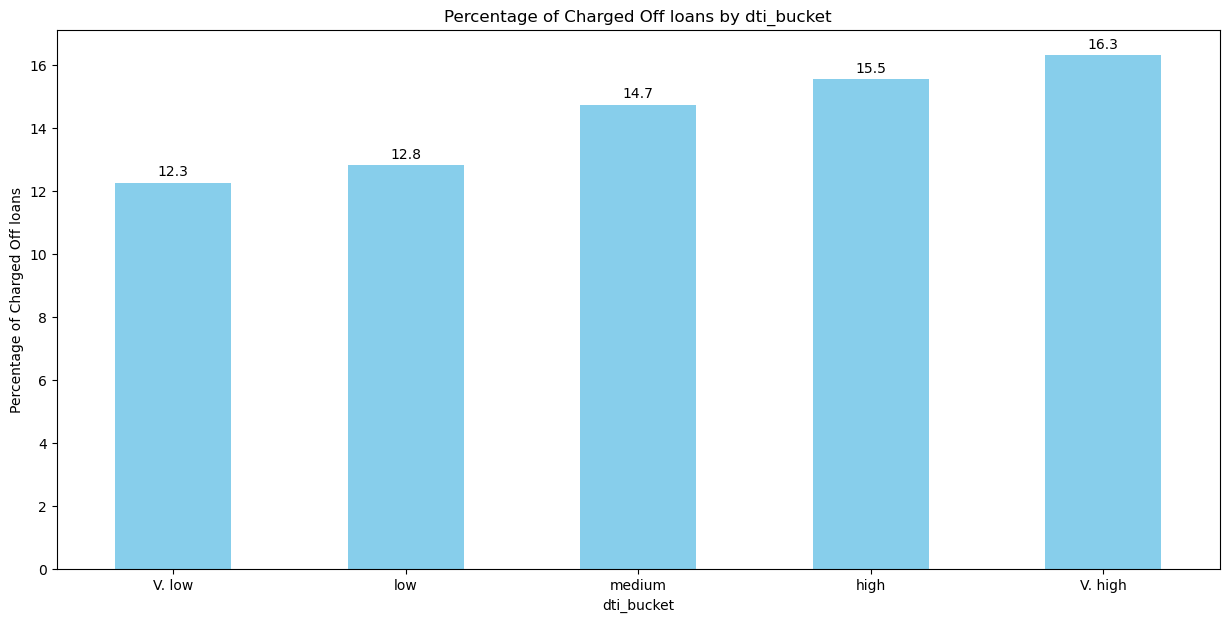

In [185]:
create_bivariate_chart(df_loan, 'dti_bucket')

<b>More dti, more is charge off percentage. Thus dti could be <u>DRIVING VARIABLE</u></b>

##### earliest_cr_line

In [186]:
# Most relevant attribute in earliest credit line is year. So let's extract year from it.
# DERIVED METRIC
df_loan['earliest_cr_line_year'] = df_loan['earliest_cr_line'].dt.year
df_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,open_acc,pub_rec,int_rate_bucket,funded_amnt_bucket,installment_bucket,annual_inc_bucket,issue_month,issue_year,dti_bucket,earliest_cr_line_year
0,5000,5000,4975.0,36,10.65,162.87,B,B2,10,RENT,...,3,0,low,V. low,low,V. low,12,2011,V. high,1985
1,2500,2500,2500.0,60,15.27,59.83,C,C4,0,RENT,...,3,0,V. high,V. low,V. low,V. low,12,2011,V. low,1999
2,2400,2400,2400.0,36,15.96,84.33,C,C5,10,RENT,...,2,0,V. high,V. low,V. low,V. low,12,2011,low,2001
3,10000,10000,10000.0,36,13.49,339.31,C,C1,10,RENT,...,10,0,high,medium,high,low,12,2011,V. high,1996
5,5000,5000,5000.0,36,7.90,156.46,A,A4,3,RENT,...,9,0,V. low,V. low,low,V. low,12,2011,low,2004


In [187]:
segmented_pivot_table('earliest_cr_line_year', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
earliest_cr_line_year,,,,,
2007,137,533,670,20.447761,79.552239
1973,8,32,40,20.000000,80.000000
2006,211,900,1111,18.991899,81.008101
2008,27,116,143,18.881119,81.118881
1979,21,93,114,18.421053,81.578947
1983,42,202,244,17.213115,82.786885
2005,226,1188,1414,15.983027,84.016973
1997,336,1779,2115,15.886525,84.113475
2000,450,2435,2885,15.597920,84.402080


<b>It is expected that customer having oldest credit history must be the low risk customer but there is no such trend observed. Thus this column <u>cannot</u> be driving variable</b>

##### open_acc

<Axes: >

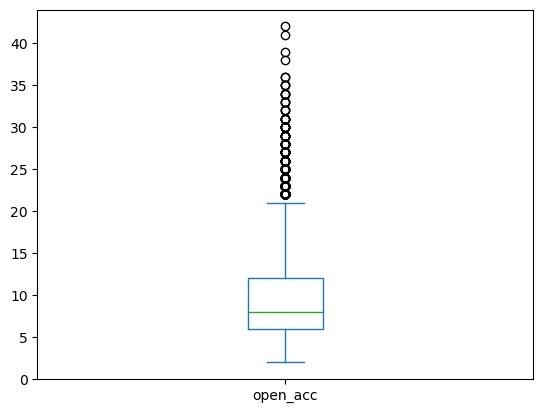

In [188]:
df_loan['open_acc'].plot.box()

<Axes: >

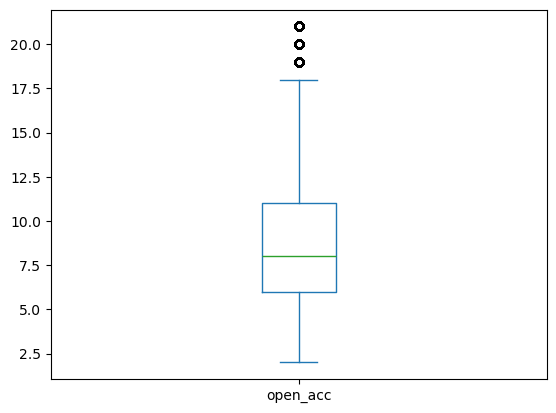

In [189]:
# As there are outliers in open_acc, so let's remove them
df_loan = remove_outliers('open_acc')
df_loan['open_acc'].plot.box()

In [190]:
# Let's divide open_acc in 5 quartiles V.low, low, medium, high and V. high
# DERIVED METRIC
df_loan['open_acc_bucket'] = pd.qcut(df_loan['open_acc'], q=[0,0.2,0.4,0.6,0.8,1], labels=['V. low', 'low', 'medium', 'high', 'V. high'])
df_loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pub_rec,int_rate_bucket,funded_amnt_bucket,installment_bucket,annual_inc_bucket,issue_month,issue_year,dti_bucket,earliest_cr_line_year,open_acc_bucket
0,5000,5000,4975.0,36,10.65,162.87,B,B2,10,RENT,...,0,low,V. low,low,V. low,12,2011,V. high,1985,V. low
1,2500,2500,2500.0,60,15.27,59.83,C,C4,0,RENT,...,0,V. high,V. low,V. low,V. low,12,2011,V. low,1999,V. low
2,2400,2400,2400.0,36,15.96,84.33,C,C5,10,RENT,...,0,V. high,V. low,V. low,V. low,12,2011,low,2001,V. low
3,10000,10000,10000.0,36,13.49,339.31,C,C1,10,RENT,...,0,high,medium,high,low,12,2011,V. high,1996,high
5,5000,5000,5000.0,36,7.90,156.46,A,A4,3,RENT,...,0,V. low,V. low,low,V. low,12,2011,low,2004,medium


In [191]:
segmented_pivot_table('open_acc_bucket', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
open_acc_bucket,,,,,
V. low,1036,5785,6821,15.188389,84.811611
V. high,885,5344,6229,14.207738,85.792262
high,975,5904,6879,14.173572,85.826428
medium,930,5698,6628,14.031382,85.968618
low,980,6054,7034,13.932329,86.067671


<b>There is very small percentage difference which can be due to <u>Randomness</u>. Further there is no trend as well in values. So open_acc <u>cannot</u> driving variable</b>

##### pub_rec

In [192]:
segmented_pivot_table('pub_rec', df_loan)

loan_status,Charged Off,Fully Paid,Total,Charged Off Percentage,Fully Paid Percentage
pub_rec,,,,,
2,10,32,42,23.809524,76.190476
1,392,1386,1778,22.047244,77.952756
0,4404,27359,31763,13.865189,86.134811
3,0,6,6,0.000000,100.000000
4,0,2,2,0.000000,100.000000


<b>Very strange pattern observed. Customers having high public records have paid loans while those having low public reocords those loans charged off. This is not expected behaviour and it could be due to <u>Randomness</u> or lack of data. So we <u>cannot</u> consider it driving variable</b>

<hr/>

##### RESULT: <p style="color:red">From above analysis we can say that term, int_rate, grade, home_ownership, annual_inc, purpose, dti are DRIVING VARIABLES. These variables can help in determining bank if customer has potential to default or not.</p>

<hr/>

#### Multivariate Analysis

In [193]:
# Let's see correlation between quantitative driving variables
df_loan[['int_rate', 'annual_inc', 'dti']].corr()

,int_rate,annual_inc,dti
int_rate,1.000000,0.009127,0.102503
annual_inc,0.009127,1.000000,-0.086772
dti,0.102503,-0.086772,1.000000


<b>As we can see correlation between driving variables is approximatly near 0 which means that there is no relation and variables are independent. This is expected as driving variables must be independent.</b>

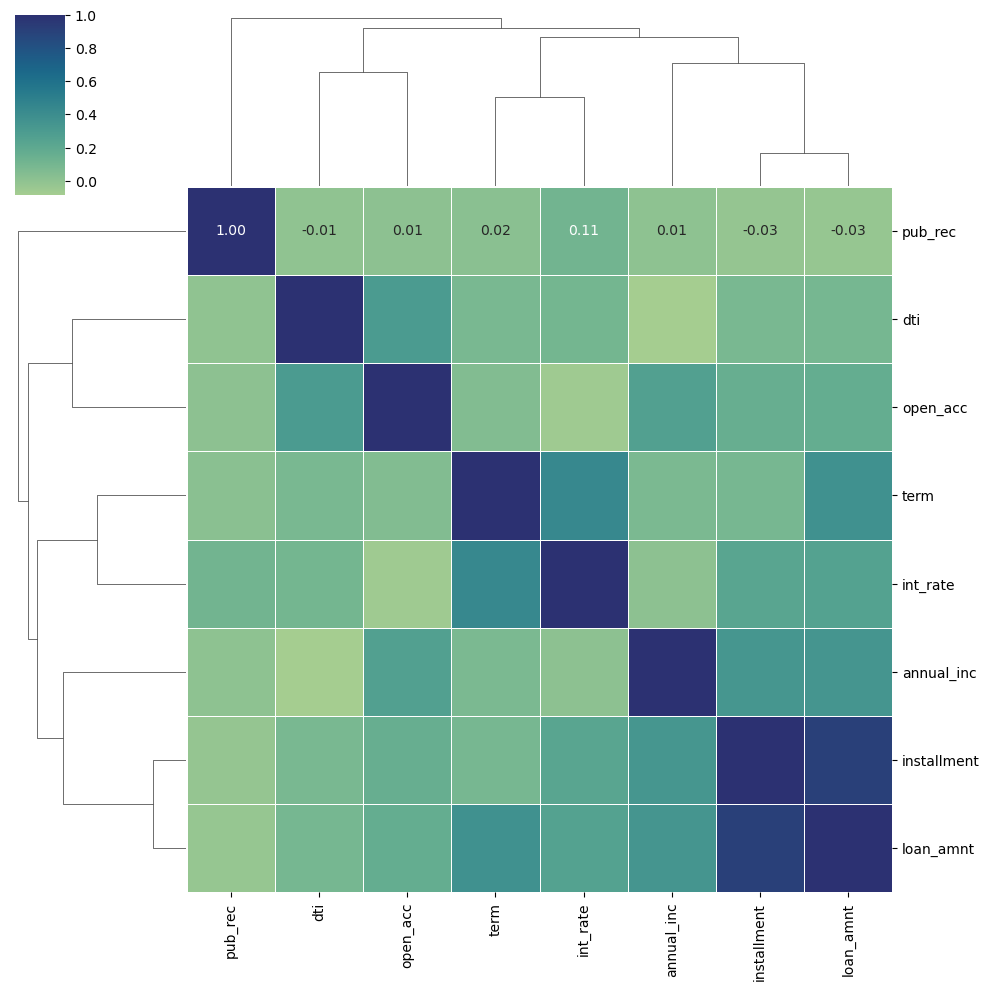

In [194]:
dataplot = sns.clustermap(
    df_loan[['installment', 'loan_amnt', 'pub_rec', 'term', 'int_rate', 'dti', 'open_acc', 'annual_inc']].corr(),
    cmap='crest',
    fmt='.2f',
    annot=True,
    linewidth=.5
)

<b>There is a significant positive correlation between loan amount and installment</b>
<br/><br/>
<b>There is a comparable positive correlation between loan amount and annual income, term and interest rate, debt to income ratio and Number of open accounts</b>
<br/><br/>
<b>Number of public records does not have a correlation between any of the parameters</b>